# Autoregressive HMM - model comparison

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
# from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import LinearAutoregressiveHMM
from dynamax.utils.plotting import gradient_cmap
from dynamax.utils.utils import random_rotation

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from fitting_functions import cross_validate_armodel, compute_inputs
from plotting_functions import plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates

one = ONE()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/api.py:1465: UserWarning: Newer cache tables require ONE version 2.7 or greater
  warnings.warn(f'Newer cache tables require ONE version {min_version} or greater')


## Parameters

In [41]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
#data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
data_path_v3 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v3_1Jul2024/' + str(bin_size) + '/'

data_path = data_path_v3

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']
       var_names = ['avg_wheel_vel', 'whisker_me']
       var_names = ['avg_wheel_vel']
elif data_path == data_path_v3:
       var_names = [ 'wheel_final', 'Lick count', 'pupil_diameter', 'whisker_me',
       'left_X', 'left_Y', 'pupil_X', 'pupil_Y', 'nose_X', 'nose_Y']
       var_names = ['Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

List design matrices' eids

In [42]:
# Save data of all sessions for latter
idxs = []
mouse_names = []
for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    eid = design_matrices[m][14:50]
    idx = str(eid + '_' + mouse_name)
    if m == 0:
        idxs = idx
        mouse_names = mouse_name
    else:
        idxs = np.hstack((idxs, idx))
        mouse_names = np.hstack((mouse_names, mouse_name))

In [43]:
idxs = ['51e53aff-1d5d-4182-a684-aba783d50ae5_NYU-45']
mouse_names = ['NYU-45']

## Preprocess list of design matrices

- Each session is saved under the mouse name; concatenated with other sessions of the same mouse;
- Only data up to trial 90 is kept;
- Data is normalized and standardized

In [44]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mouse_name in enumerate(mouse_names):
    # Save results per mouse
    matrix_all[mouse_name] = {}
    session_all[mouse_name] = {}
    matrix_all_unnorm[mouse_name] = {}

for m, mat in enumerate(idxs): # [5:6]
    if len(mat) > 35: 
            
        # Trials data
        session = mat[0:36]
        mouse_name = mat[37:]
        
        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()
        session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        session_start = list(session_trials['stimOn_times'])[0]

        # Get time of last unbiased trial
        unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
        time_trial_90 = list(unbiased['stimOff_times'])[-1]
        
        filename = str('design_matrix_' + mat + '_'  + str(bin_size))  # + mouse_name + '_'
        big_design_matrix = pickle.load(open(filename, "rb"))
        design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
        design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
        design_matrix = design_matrix.dropna()
    
        # Keep only first 90 trials
        design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
        unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
        training_set = np.array(design_matrix[var_names]).copy() 
        
        if len(training_set) > 0:
            # Standardization using StandardScaler
            scaler = StandardScaler()
            standardized = scaler.fit_transform(training_set)
            # Normalize between 0 and 1
            normalizer = Normalizer()
            normalized = normalizer.fit_transform(standardized)
            
            if len(var_names)>1:
                matrix_all[mouse_name][session] = normalized
            else:
                matrix_all[mouse_name][session] = standardized
                
            session_all[mouse_name][session] = unbiased_trials    
            matrix_all_unnorm[mouse_name][session] = design_matrix
            
        else:
            print(session)
    else:
        print(mat)

## Parameters

In [45]:
num_iters = 100
num_train_batches = 5
method = 'kmeans'

# Plotting params
bin_size = 0.1

## Concatenate sessions of the same animal

In [6]:
collapsed_matrices = defaultdict(list)
collapsed_unnorm = defaultdict(list)
collapsed_trials = defaultdict(list)

# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        mouse_sessions = list(matrix_all[mouse].keys())
        for s, session in enumerate(mouse_sessions):
            collapsed_matrices[mouse] = np.vstack(matrix_all[mouse][session])
            collapsed_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse][session])
            collapsed_trials[mouse] = pd.concat(session_all[mouse], ignore_index=True)

## Fit multiple states

In [ ]:
last_state = 20  # Test up until last_state Ks
state_step = 2
start_step = 2

num_lags = 1  # First order ARHMM

In [8]:
# Initialize vars for saving results
all_init_params = defaultdict(list)
all_fit_params = defaultdict(list)
all_lls = defaultdict(list)
all_baseline_lls = defaultdict(list)

for m, mat in enumerate(idxs[0:2]):
    if len(mat) > 35: 
            
        # Trials data
        session = mat[0:36]
        # Mouse name
        mouse_name = mat[37:]
        
        print('Fitting mouse ' + mouse_name)
    
        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

        # Compute inputs for required timelags
        my_inputs = compute_inputs(shortened_array, num_lags, emission_dim)
        train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
        
        " Fit model with cross-validation across states "

        # Make a range of Gaussian HMMs
        all_num_states = list(range(start_step, last_state, state_step))
        test_arhmms = [LinearAutoregressiveHMM(num_states, emission_dim, num_lags=num_lags) 
            for num_states in all_num_states]
        results = []
        for test_arhmm in test_arhmms:
            print(f"fitting model with {test_arhmm.num_states} states")
            results.append(cross_validate_armodel(test_arhmm, jr.PRNGKey(0), shortened_array, 
                                                train_emissions, train_inputs, method, num_train_batches))

        all_val_lls, fit_params, init_params, baseline_lls= tuple(zip(*results))
            
        # Save results
        all_lls[mouse_name] = {}
        all_baseline_lls[mouse_name] = {}
        all_init_params[mouse_name] = {}
        all_fit_params[mouse_name] = {}
        
        all_lls[mouse_name][session] = all_val_lls
        all_baseline_lls[mouse_name][session] = baseline_lls
        all_init_params[mouse_name][session] = init_params
        all_fit_params[mouse_name][session] = fit_params


Fitting mouse SWC_052
fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 10 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 12 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 14 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 16 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 18 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting mouse ZFM-02369
fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 10 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 12 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 14 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 16 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 18 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Plot goodness of fit across states

Fitting mouse SWC_052


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)


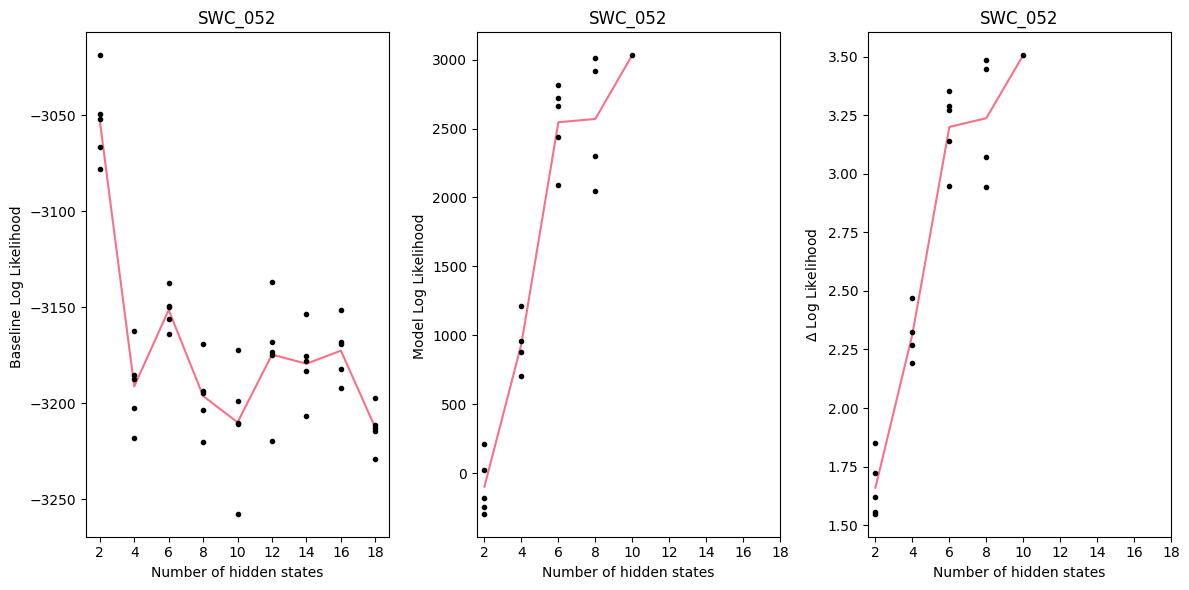

In [9]:
States = list(range(start_step, last_state, state_step))

def generate_colors(num_colors):
    # Use seaborn's color_palette to generate a list of colors
    return sns.color_palette('husl', n_colors=num_colors)

# Generate the list of colors
colors = generate_colors(len(np.unique(mouse_names)))
Ks = np.array([(num_states + num_states*num_states + num_states*emission_dim*2) 
          for num_states in States]) 


for m, mat in enumerate(idxs[0:1]):
    if len(mat) > 35: 
            
        # Trials data
        session = mat[0:36]
        # Mouse name
        mouse_name = mat[37:]
        
        print('Fitting mouse ' + mouse_name)
    
        
        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

        # Split data into folds
        fold_len =  len(shortened_array)/num_train_batches
        
        # avg_val_lls = all_lls[mouse_name][0]
        # baseline_lls = all_baseline_lls[mouse_name][0]
        
        avg_val_lls = all_lls[mouse_name][session]
        baseline_lls = all_baseline_lls[mouse_name][session]
        
        bits_LL = (np.array(avg_val_lls) - np.array(baseline_lls)) / fold_len * np.log(2)
        
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=[12, 6])
        
        axs[0].plot(all_num_states, np.nanmean(baseline_lls, axis=1), color=colors[m], label=str(session))
        for k, per_fold_val_lls in zip(all_num_states, baseline_lls):
            axs[0].plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.', color='k')
        axs[0].legend()
        axs[0].set_title(mouse_name)
        axs[0].set_xticks(States)
        axs[0].set_xlabel("Number of hidden states")
        axs[0].set_ylabel("Baseline Log Likelihood ")
        
        axs[1].plot(all_num_states, np.nanmean(avg_val_lls, axis=1), color=colors[m], label=str(session))
        for k, per_fold_val_lls in zip(all_num_states, avg_val_lls):
            axs[1].plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.', color='k')
        axs[1].legend()
        axs[1].set_title(mouse_name)
        axs[1].set_xticks(States)
        axs[1].set_xlabel("Number of hidden states")
        axs[1].set_ylabel("Model Log Likelihood ")
        
        axs[2].plot(all_num_states, np.nanmean(bits_LL, axis=1), color=colors[m], label=str(session))
        for k, per_fold_val_lls in zip(all_num_states, bits_LL):
            axs[2].plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.', color='k')
        axs[2].legend()
        axs[2].set_title(mouse_name)
        axs[2].set_xticks(States)
        axs[2].set_xlabel("Number of hidden states")
        axs[2].set_ylabel("$\Delta$ Log Likelihood ")
#axs[0].set_xticks(np.arange(0, last_state, 10), np.arange(0, last_state, 10))
axs[0].legend().remove()
axs[1].legend().remove()
axs[2].legend().remove()
plt.tight_layout()
plt.show()


## Fit multiple lags

In [40]:
num_states = 5
last_lag = 10  # Test up until last_state Ks
lag_step = 2
start_lag = 1

# Initialize vars for saving results
all_init_params = defaultdict(list)
all_fit_params = defaultdict(list)
all_lls = defaultdict(list)
all_baseline_lls = defaultdict(list)

# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)):
    
    if len(mouse_name) > 0:
        
        print('Fitting mouse ' + mouse_name)
    
        # Get mouse data
        session_trials = session_all[mouse_name]
        design_matrix = matrix_all[mouse_name]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

        " Fit model with cross-validation across states "

        # Make a range of Gaussian HMMs
        all_num_lags = list(range(start_lag, last_lag, lag_step))
        test_arhmms = [LinearAutoregressiveHMM(num_states, emission_dim, num_lags) 
            for num_lags in all_num_lags]
        results = []
        for test_arhmm in test_arhmms:
            print(f"fitting model with {test_arhmm.num_lags} lags")
            # Compute inputs for required timelags
            my_inputs = compute_inputs(shortened_array, test_arhmm.num_lags, emission_dim)
            train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
        
            results.append(cross_validate_armodel(test_arhmm, jr.PRNGKey(0), shortened_array, 
                                                train_emissions, train_inputs, method, num_train_batches))

        all_val_lls, fit_params, init_params, baseline_lls= tuple(zip(*results))
            
        # Save results
        all_lls[mouse_name].append(all_val_lls)
        all_baseline_lls[mouse_name].append(baseline_lls)
        all_init_params[mouse_name].append(init_params)
        all_fit_params[mouse_name].append(fit_params)


Fitting mouse CSHL060
fitting model with 1 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting mouse DY_013
fitting model with 1 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting mouse DY_014
fitting model with 1 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting mouse DY_016
fitting model with 1 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting mouse KS096
fitting model with 1 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting mouse NYU-40
fitting model with 1 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting mouse PL015
fitting model with 1 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 lags


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

### Plot goodness of fit across lags

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)


IndexError: list index out of range

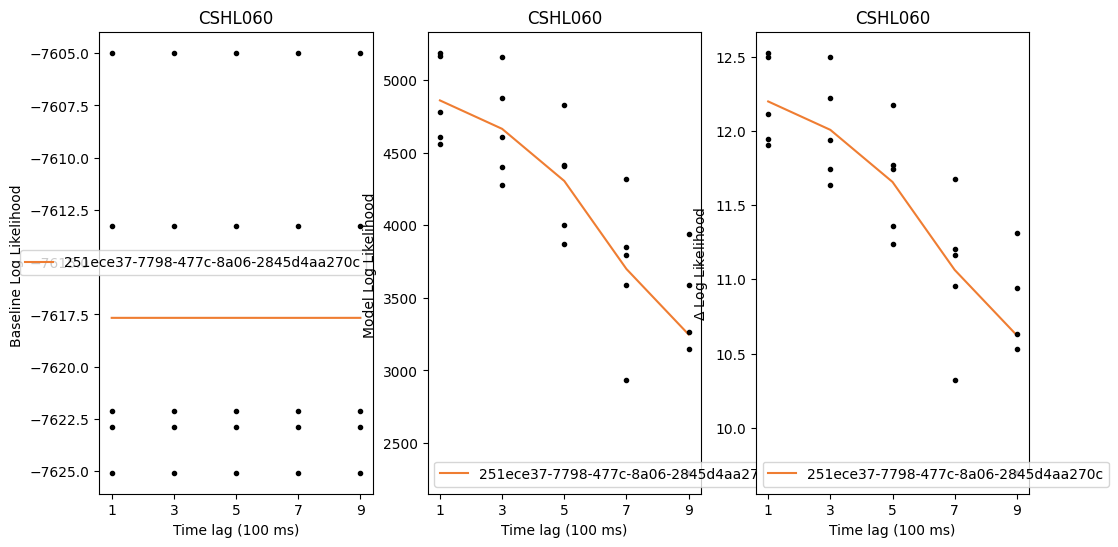

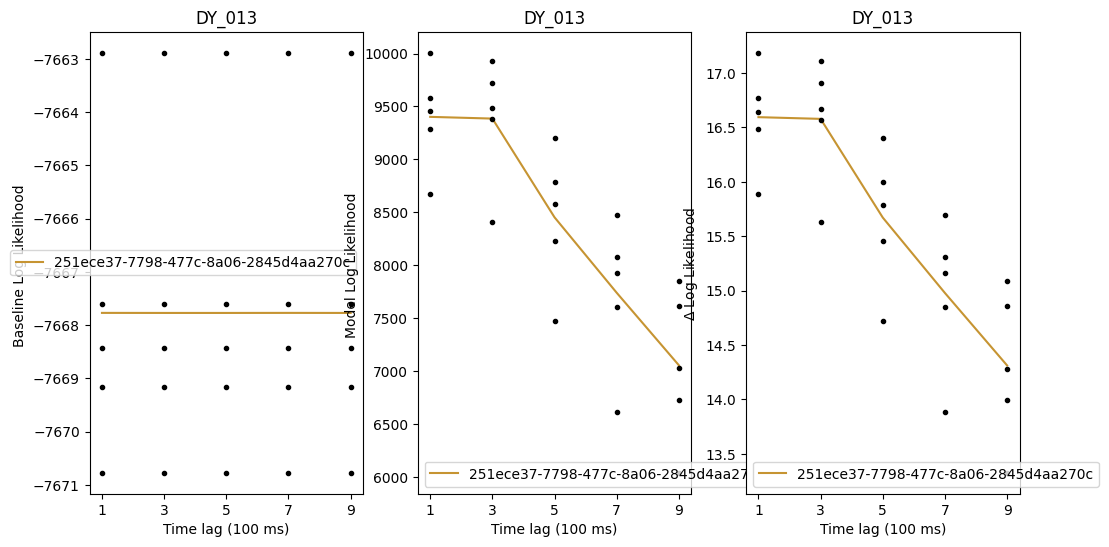

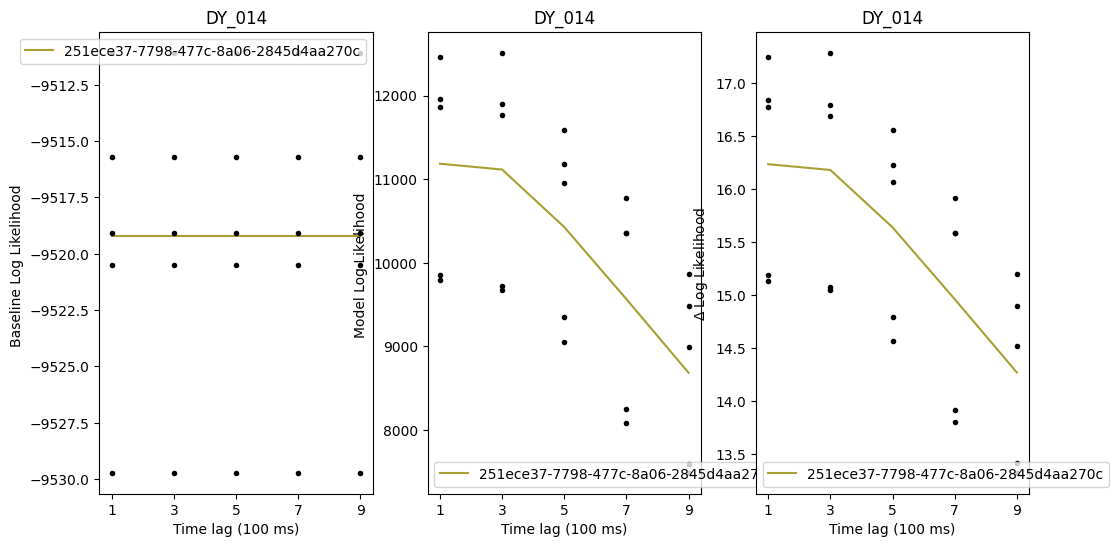

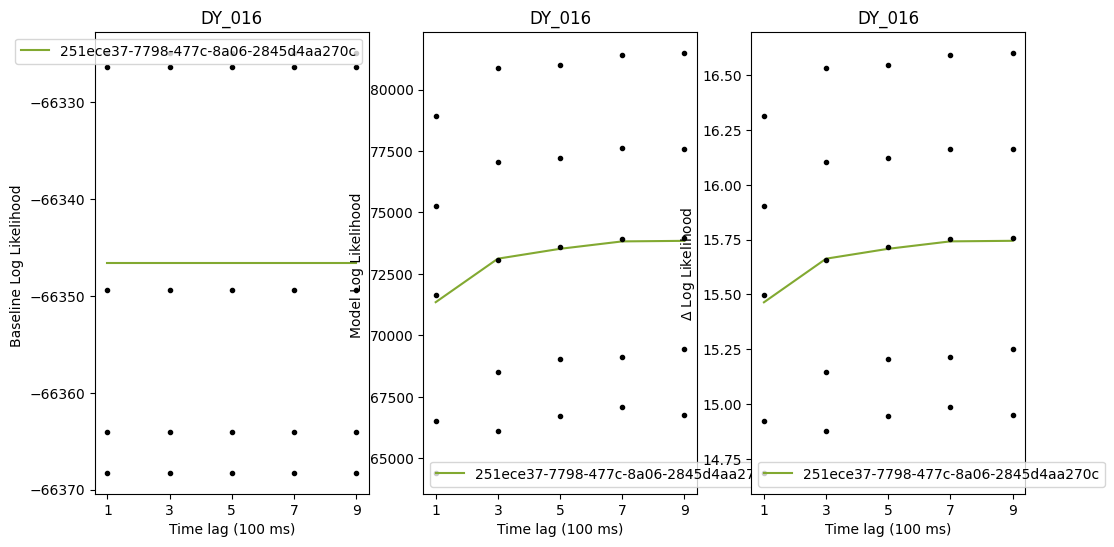

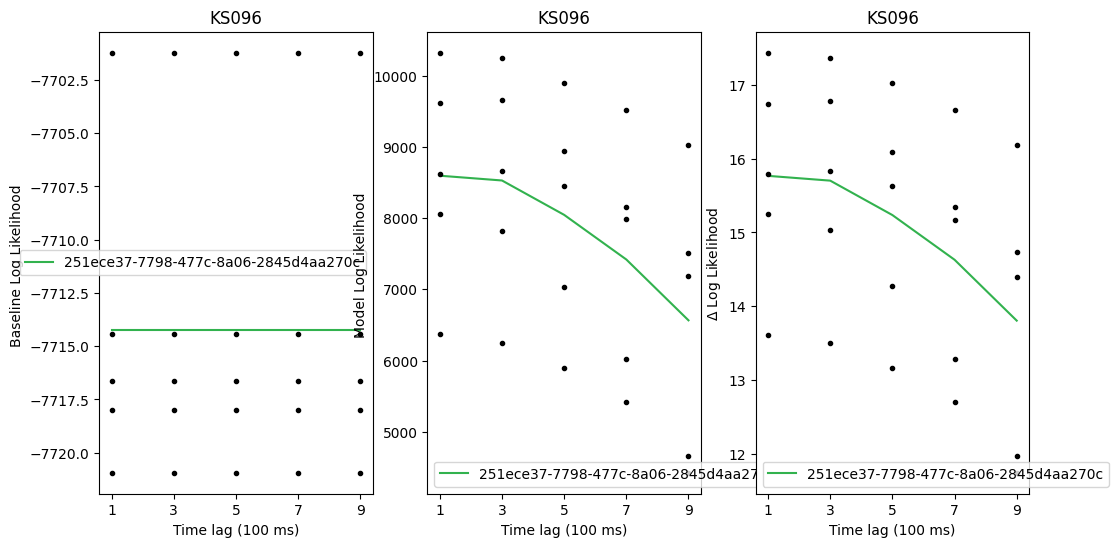

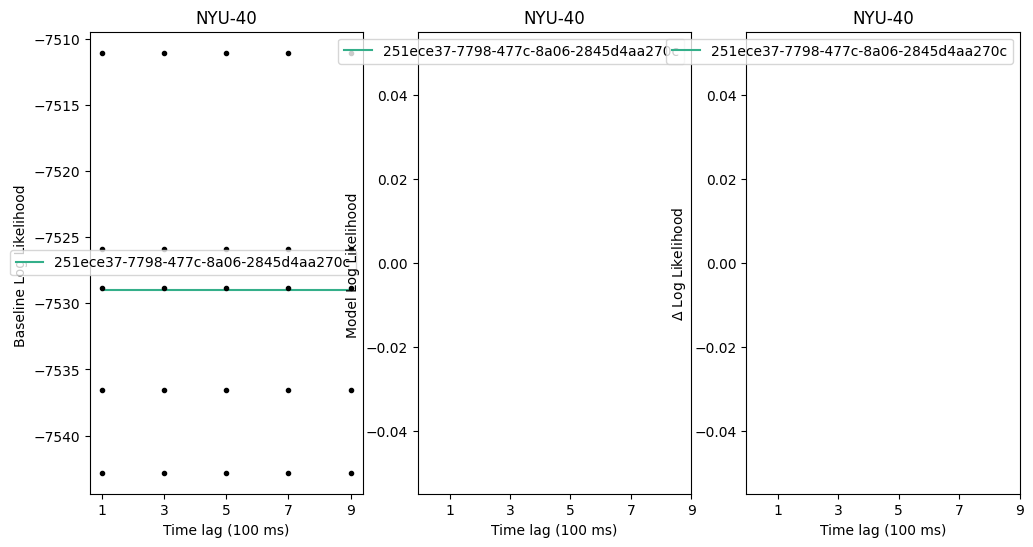

In [41]:
Lags = list(range(start_lag, last_lag, lag_step))

def generate_colors(num_colors):
    # Use seaborn's color_palette to generate a list of colors
    return sns.color_palette('husl', n_colors=num_colors)

# Generate the list of colors
colors = generate_colors(len(np.unique(mouse_names)))
Ks = np.array([(num_states + num_states*num_states + num_states*emission_dim*3)])  # number of states is fixed 

# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)):
    
    if len(mouse_name) > 0:
        
        # Get mouse data
        session_trials = session_all[mouse_name]
        design_matrix = matrix_all[mouse_name]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

        # Split data into folds
        fold_len =  len(shortened_array)/num_train_batches
        
        avg_val_lls = all_lls[mouse_name][0]
        baseline_lls = all_baseline_lls[mouse_name][0]
        bits_LL = (np.array(avg_val_lls) - np.array(baseline_lls)) / fold_len * np.log(2)
        
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=[12, 6])
        
        axs[0].plot(all_num_lags, np.nanmean(baseline_lls, axis=1), color=colors[m], label=str(session))
        for k, per_fold_val_lls in zip(all_num_lags, baseline_lls):
            axs[0].plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.', color='k')
        axs[0].legend()
        axs[0].set_title(mouse_name)
        axs[0].set_xticks(Lags)
        axs[0].set_xlabel("Time lag (100 ms)")
        axs[0].set_ylabel("Baseline Log Likelihood ")
        
        axs[1].plot(all_num_lags, np.nanmean(avg_val_lls, axis=1), color=colors[m], label=str(session))
        for k, per_fold_val_lls in zip(all_num_lags, avg_val_lls):
            axs[1].plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.', color='k')
        axs[1].legend()
        axs[1].set_title(mouse_name)
        axs[1].set_xticks(Lags)
        axs[1].set_xlabel("Time lag (100 ms)")
        axs[1].set_ylabel("Model Log Likelihood ")
        
        axs[2].plot(all_num_lags, np.nanmean(bits_LL, axis=1), color=colors[m], label=str(session))
        for k, per_fold_val_lls in zip(all_num_lags, bits_LL):
            axs[2].plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.', color='k')
        axs[2].legend()
        axs[2].set_title(mouse_name)
        axs[2].set_xticks(Lags)
        axs[2].set_xlabel("Time lag (100 ms)")
        axs[2].set_ylabel("$\Delta$ Log Likelihood ")
#axs[0].set_xticks(np.arange(0, last_state, 10), np.arange(0, last_state, 10))
axs[0].legend().remove()
axs[1].legend().remove()
axs[2].legend().remove()
plt.tight_layout()
plt.show()


## Grid search over number of states and lag

This took 161 minutes to run

In [14]:
last_state = 10 
state_step = 2
start_state = 4
all_num_states = list(range(start_state, last_state, state_step))

last_lag = 3 
lag_step = 1
start_lag = 1
all_num_lags = list(range(start_lag, last_lag, lag_step))

stickiness = [10, 100, 500, 1000]

# Initialize vars for saving results
all_init_params = defaultdict(list)
all_fit_params = defaultdict(list)
all_lls = defaultdict(list)
all_baseline_lls = defaultdict(list)

# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)[0:2]):
    
    if len(mouse_name) > 0:
        
        # Initialize mouse 
        all_lls[mouse_name] = {}
        all_baseline_lls[mouse_name] = {}
        all_init_params[mouse_name] = {}
        all_fit_params[mouse_name] = {}
        
        print('Fitting mouse ' + mouse_name)
    
        # Get mouse data
        session_trials = session_all[mouse_name]
        design_matrix = matrix_all[mouse_name]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        " Fit model with cross-validation across states and lags "
        for lag in all_num_lags:
            
            print(f"fitting model with {lag} lags")
            # Initialize lag 
            all_lls[mouse_name][lag] = {}
            all_baseline_lls[mouse_name][lag] = {}
            all_init_params[mouse_name][lag] = {}
            all_fit_params[mouse_name][lag] = {}
            
            for stick in stickiness:
                
                print(f"fitting model with stickiness {stick}")
                # Initialize stickiness 
                all_lls[mouse_name][lag][stick] = {}
                all_baseline_lls[mouse_name][lag][stick] = {}
                all_init_params[mouse_name][lag][stick] = {}
                all_fit_params[mouse_name][lag][stick] = {}
            
                # Make a range of Gaussian HMMs
                test_arhmms = [LinearAutoregressiveHMM(num_states, emission_dim, num_lags=lag, transition_matrix_stickiness=stick) 
                    for num_states in all_num_states]
                results = []
                
                # Loop through states
                for test_arhmm in test_arhmms:
                    print(f"fitting model with {test_arhmm.num_states} states")
                    # Compute inputs for required timelags
                    my_inputs = compute_inputs(shortened_array, lag, emission_dim)
                    train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
                
                    results.append(cross_validate_armodel(test_arhmm, jr.PRNGKey(0), shortened_array, 
                                                        train_emissions, train_inputs, method, num_train_batches))
            
                # Save results per states
                all_val_lls, fit_params, init_params, baseline_lls= tuple(zip(*results))
                
                # Save results
                all_lls[mouse_name][lag][stick] = all_val_lls
                all_baseline_lls[mouse_name][lag][stick] = baseline_lls
                all_init_params[mouse_name][lag][stick] = init_params
                all_fit_params[mouse_name][lag][stick] = fit_params

Fitting mouse CSHL060
fitting model with 1 lags
fitting model with stickiness 10
fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with stickiness 100
fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with stickiness 500
fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with stickiness 1000
fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 2 lags
fitting model with stickiness 10
fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with stickiness 100
fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with stickiness 500
fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with stickiness 1000
fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


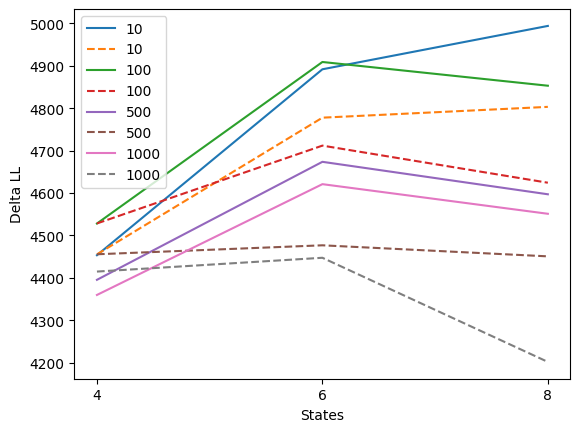

In [23]:
use = all_lls['CSHL060'][1]
labels=[10, 100, 500, 1000]
for stick in [10, 100, 500, 1000]:
    states = np.nanmean(all_lls['CSHL060'][1][stick], axis=1)
    plt.plot(states, label=stick)
    plt.xticks([0, 1, 2], all_num_states)
    plt.legend()
    states = np.nanmean(all_lls['CSHL060'][2][stick], axis=1)
    plt.plot(states, label=stick, linestyle='--')
    plt.xticks([0, 1, 2], all_num_states)
    plt.xlabel('States')
    plt.ylabel('Delta LL')
    plt.legend()

## Grid search over kappas and lag

In [46]:
num_states = 2

last_lag = 20
lag_step = 2
start_lag = 1
all_num_lags = list(range(start_lag, last_lag, lag_step))

kappas = [0, 5, 10, 50, 100, 500, 800, 1000, 1500]
kappas = [0, 1, 5, 10, 100, 500, 1000]

# Initialize vars for saving results
all_init_params = defaultdict(list)
all_fit_params = defaultdict(list)
all_lls = defaultdict(list)
all_baseline_lls = defaultdict(list)


for m, mat in enumerate(idxs):
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        # mouse_name = 'CSHL060'
        session = mat[0:36]

        # Initialize mouse 
        all_lls[mouse_name] = {}
        all_baseline_lls[mouse_name] = {}
        all_init_params[mouse_name] = {}
        all_fit_params[mouse_name] = {}
        
        print('Fitting mouse ' + mouse_name)
        
        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]  
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
            
        " Fit model with cross-validation"
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
        
        " Fit model with cross-validation across kappas and lags "
        for lag in all_num_lags:
            
            print(f"fitting model with {lag} lags")
            # Initialize lag 
            all_lls[mouse_name][lag] = {}
            all_baseline_lls[mouse_name][lag] = {}
            all_init_params[mouse_name][lag] = {}
            all_fit_params[mouse_name][lag] = {}
            
            for kappa in kappas:
                
                print(f"fitting model with kappa {kappa}")
                # Initialize stickiness 
                all_lls[mouse_name][lag][kappa] = {}
                all_baseline_lls[mouse_name][lag][kappa] = {}
                all_init_params[mouse_name][lag][kappa] = {}
                all_fit_params[mouse_name][lag][kappa] = {}
            
                # Make a range of Gaussian HMMs
                test_arhmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=lag, transition_matrix_stickiness=kappa)
                # Compute inputs for required timelags
                my_inputs = compute_inputs(shortened_array, lag, emission_dim)
                train_inputs = jnp.stack(jnp.split(my_inputs, num_train_batches))
            
                all_val_lls, fit_params, init_params, baseline_lls = cross_validate_armodel(test_arhmm, jr.PRNGKey(0), shortened_array, 
                                                    train_emissions, train_inputs, method, num_train_batches)
            
                # Save results
                all_lls[mouse_name][lag][kappa] = all_val_lls
                all_baseline_lls[mouse_name][lag][kappa] = baseline_lls
                all_init_params[mouse_name][lag][kappa] = init_params
                all_fit_params[mouse_name][lag][kappa] = fit_params

Fitting mouse NYU-45
fitting model with 1 lags
fitting model with kappa 0


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 5


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 10


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 100


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 500


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1000


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with 3 lags
fitting model with kappa 0


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 5


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 10


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 100


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 500


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1000


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with 5 lags
fitting model with kappa 0


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 5


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 10


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 100


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 500


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1000


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with 7 lags
fitting model with kappa 0


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 5


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 10


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 100


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 500


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1000


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with 9 lags
fitting model with kappa 0


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 5


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 10


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 100


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 500


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1000


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with 11 lags
fitting model with kappa 0


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 5


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 10


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 100


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 500


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1000


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with 13 lags
fitting model with kappa 0


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 5


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 10


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 100


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 500


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1000


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with 15 lags
fitting model with kappa 0


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 5


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 10


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 100


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 500


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1000


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with 17 lags
fitting model with kappa 0


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 5


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 10


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 100


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 500


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1000


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with 19 lags
fitting model with kappa 0


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 5


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 10


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 100


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 500


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


fitting model with kappa 1000


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/dynamax/dynamax/hidden_markov_model/models/arhmm.py:47: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  km = KMeans(self.num_states, random_state=int(sklearn_key)).fit(emissions.reshape(-1, self.emission_dim))


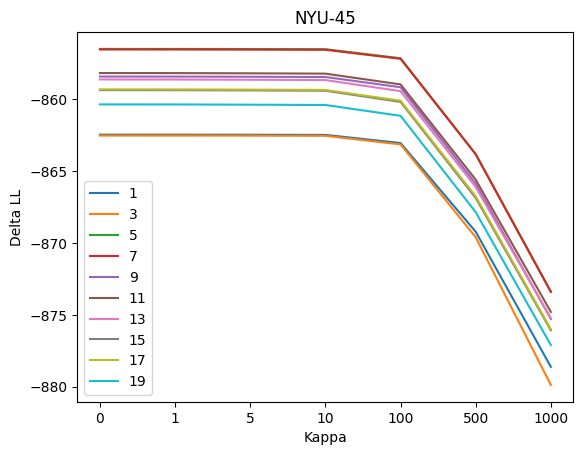

In [40]:

for m, mat in enumerate(idxs):
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        # mouse_name = 'CSHL060'
        session = mat[0:36]
        
        # Get results from grid search for that mouse
        use = all_lls[mouse_name]
        
        for l in all_num_lags:
            lag_lls = []
            for k in kappas:
                
                lag_lls.append(np.nanmean(use[l][k], axis=0))
                
            plt.plot(lag_lls, label=l)
            plt.xticks(np.arange(0, len(kappas), 1), kappas)
            plt.xlabel('Kappa')
            plt.ylabel('Delta LL')
            plt.legend()
        plt.title(mouse_name)
        plt.show()

## Plot across animals

In [8]:
lls_lag_state = defaultdict(list)

# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)):
    # mouse_name = 'DY_013'
    if len(mouse_name) > 0:

        # Initialize mouse data
        lls_lag_state[mouse_name] = {}
        
        # Get mouse data
        session_trials = session_all[mouse_name]
        design_matrix = matrix_all[mouse_name]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])

        # Split data into folds
        fold_len =  len(shortened_array)/num_train_batches
        
        for l, lag in enumerate(Lags):
            
            avg_val_lls = all_lls[mouse_name][lag]
            baseline_lls = all_baseline_lls[mouse_name][lag]
            bits_LL = (np.array(avg_val_lls) - np.array(baseline_lls)) / fold_len * np.log(2)
            
            if l == 0:
                lls_lag_state[mouse_name] = np.nanmean(bits_LL, axis=1)
            else:
                lls_lag_state[mouse_name] = np.vstack((lls_lag_state[mouse_name], np.nanmean(bits_LL, axis=1)))
    
# Find best params per mouse
best_lag = np.arange(0, len(np.unique(mouse_names)), 1) * np.nan
best_state = np.arange(0, len(np.unique(mouse_names)), 1) * np.nan
# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)):
    # mouse_name = 'DY_013'
    try:
        best_lag[m] = Lags[np.where(lls_lag_state[mouse_name]==np.nanmax(lls_lag_state[mouse_name]))[0][0]]
        best_state[m] = States[np.where(lls_lag_state[mouse_name]==np.nanmax(lls_lag_state[mouse_name]))[1][0]]
    except:
        print(mouse_name)

defaultdict(list,
            {'CSHL060': {1: {10: (Array([3270.1843, 3017.936 , 3440.2563, 2374.415 , 2481.81  ], dtype=float32),
                Array([4312.946 , 4085.4543, 4536.4688, 4242.6743, 5088.15  ], dtype=float32),
                Array([4792.539 , 4585.7446, 5092.23  , 4894.115 , 5093.5273], dtype=float32),
                Array([4847.246 , 4688.598 , 5245.0645, 4985.7607, 5202.9043], dtype=float32),
                Array([4928.9385, 4543.0557, 5105.5356, 4839.3613, 5324.5913], dtype=float32),
                Array([4663.9604, 4353.231 , 5176.881 , 4822.3174, 4863.274 ], dtype=float32),
                Array([4785.415 , 4443.4185, 5069.5093, 4871.3276, 4890.969 ], dtype=float32),
                Array([4516.326 , 4589.147 , 4943.1533, 4589.539 , 5031.0117], dtype=float32)),
               100: (Array([3262.5562, 3313.2158, 3778.1353, 3251.2734, 3565.1733], dtype=float32),
                Array([4617.0327, 4443.86  , 4597.5347, 4135.108 , 4845.71  ], dtype=float32),
        

### Plot LL for different lags and states

In [13]:
def best_params(all_lls, all_baseline_lls, mouse_names, session_all, matrix_all, num_train_batches, Lags):

    lls_lag_state = defaultdict(list)
    
    # Loop through mice
    for m, mouse_name in enumerate(np.unique(mouse_names)):
        # mouse_name = 'DY_013'
        if len(mouse_name) > 0:

            # Initialize mouse data
            lls_lag_state[mouse_name] = {}
            
            # Get mouse data
            session_trials = session_all[mouse_name]
            design_matrix = matrix_all[mouse_name]
            
            if len(np.shape(design_matrix)) > 2:
                design_matrix = design_matrix[0]
                session_trials = session_trials[0]
                
            # Prepare data for cross-validation
            num_timesteps = np.shape(design_matrix)[0]
            shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])

            # Split data into folds
            fold_len =  len(shortened_array)/num_train_batches
            
            for l, lag in enumerate(Lags):
                
                avg_val_lls = all_lls[mouse_name][lag]
                baseline_lls = all_baseline_lls[mouse_name][lag]
                bits_LL = (np.array(avg_val_lls) - np.array(baseline_lls)) / fold_len * np.log(2)
                
                if l == 0:
                    lls_lag_state[mouse_name] = np.nanmean(bits_LL, axis=1)
                else:
                    lls_lag_state[mouse_name] = np.vstack((lls_lag_state[mouse_name], np.nanmean(bits_LL, axis=1)))
        
    # Find best params per mouse
    best_lag = np.arange(0, len(np.unique(mouse_names)), 1) * np.nan
    best_state = np.arange(0, len(np.unique(mouse_names)), 1) * np.nan
    # Loop through mice
    for m, mouse_name in enumerate(np.unique(mouse_names)):
        # mouse_name = 'DY_013'
        try:
            best_lag[m] = Lags[np.where(lls_lag_state[mouse_name]==np.nanmax(lls_lag_state[mouse_name]))[0][0]]
            best_state[m] = States[np.where(lls_lag_state[mouse_name]==np.nanmax(lls_lag_state[mouse_name]))[1][0]]
        except:
            print(mouse_name)
            
    return best_lag, best_state, lls_lag_state


def generate_colors(num_colors):
    # Use seaborn's color_palette to generate a list of colors
    return sns.color_palette('husl', n_colors=num_colors)

In [ ]:










def best_params(all_lls, all_baseline_lls, mouse_names, session_all, matrix_all, num_train_batches, Lags):

    lls_lag_state = defaultdict(list)
    
    # Loop through mice
    for m, mouse_name in enumerate(np.unique(mouse_names)):
        # mouse_name = 'DY_013'
        if len(mouse_name) > 0:

            # Initialize mouse data
            lls_lag_state[mouse_name] = {}
            
            # Get mouse data
            session_trials = session_all[mouse_name]
            design_matrix = matrix_all[mouse_name]
            
            if len(np.shape(design_matrix)) > 2:
                design_matrix = design_matrix[0]
                session_trials = session_trials[0]
                
            # Prepare data for cross-validation
            num_timesteps = np.shape(design_matrix)[0]
            shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])

            # Split data into folds
            fold_len =  len(shortened_array)/num_train_batches
            
            for l, lag in enumerate(Lags):
                
                avg_val_lls = all_lls[mouse_name][lag]
                baseline_lls = all_baseline_lls[mouse_name][lag]
                bits_LL = (np.array(avg_val_lls) - np.array(baseline_lls)) / fold_len * np.log(2)
                
                if l == 0:
                    lls_lag_state[mouse_name] = np.nanmean(bits_LL, axis=1)
                else:
                    lls_lag_state[mouse_name] = np.vstack((lls_lag_state[mouse_name], np.nanmean(bits_LL, axis=1)))
        
    # Find best params per mouse
    best_lag = np.arange(0, len(np.unique(mouse_names)), 1) * np.nan
    best_state = np.arange(0, len(np.unique(mouse_names)), 1) * np.nan
    # Loop through mice
    for m, mouse_name in enumerate(np.unique(mouse_names)):
        # mouse_name = 'DY_013'
        try:
            best_lag[m] = Lags[np.where(lls_lag_state[mouse_name]==np.nanmax(lls_lag_state[mouse_name]))[0][0]]
            best_state[m] = States[np.where(lls_lag_state[mouse_name]==np.nanmax(lls_lag_state[mouse_name]))[1][0]]
        except:
            print(mouse_name)
            
    return best_lag, best_state, lls_lag_state

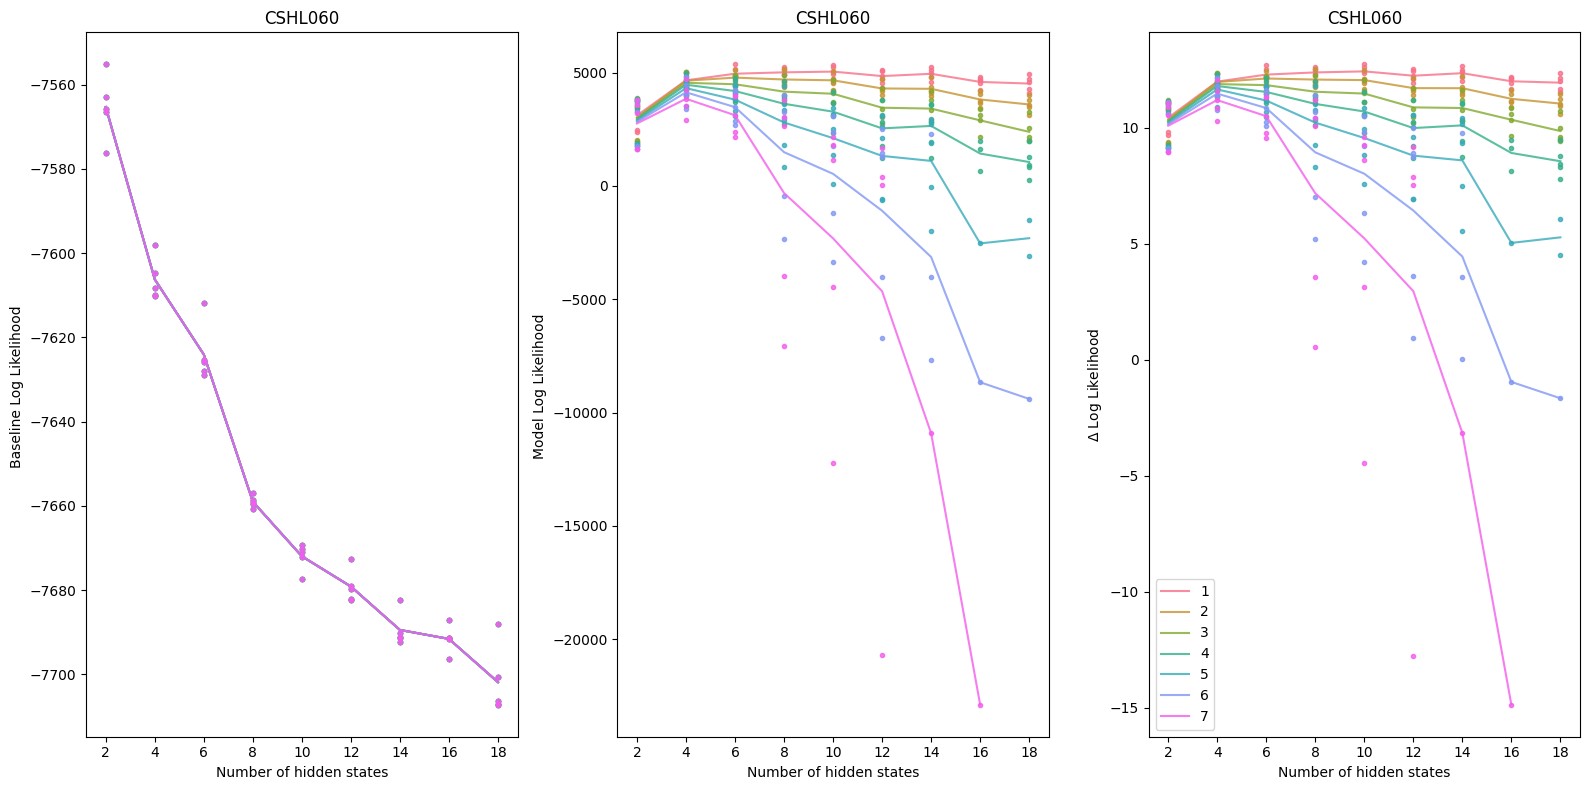

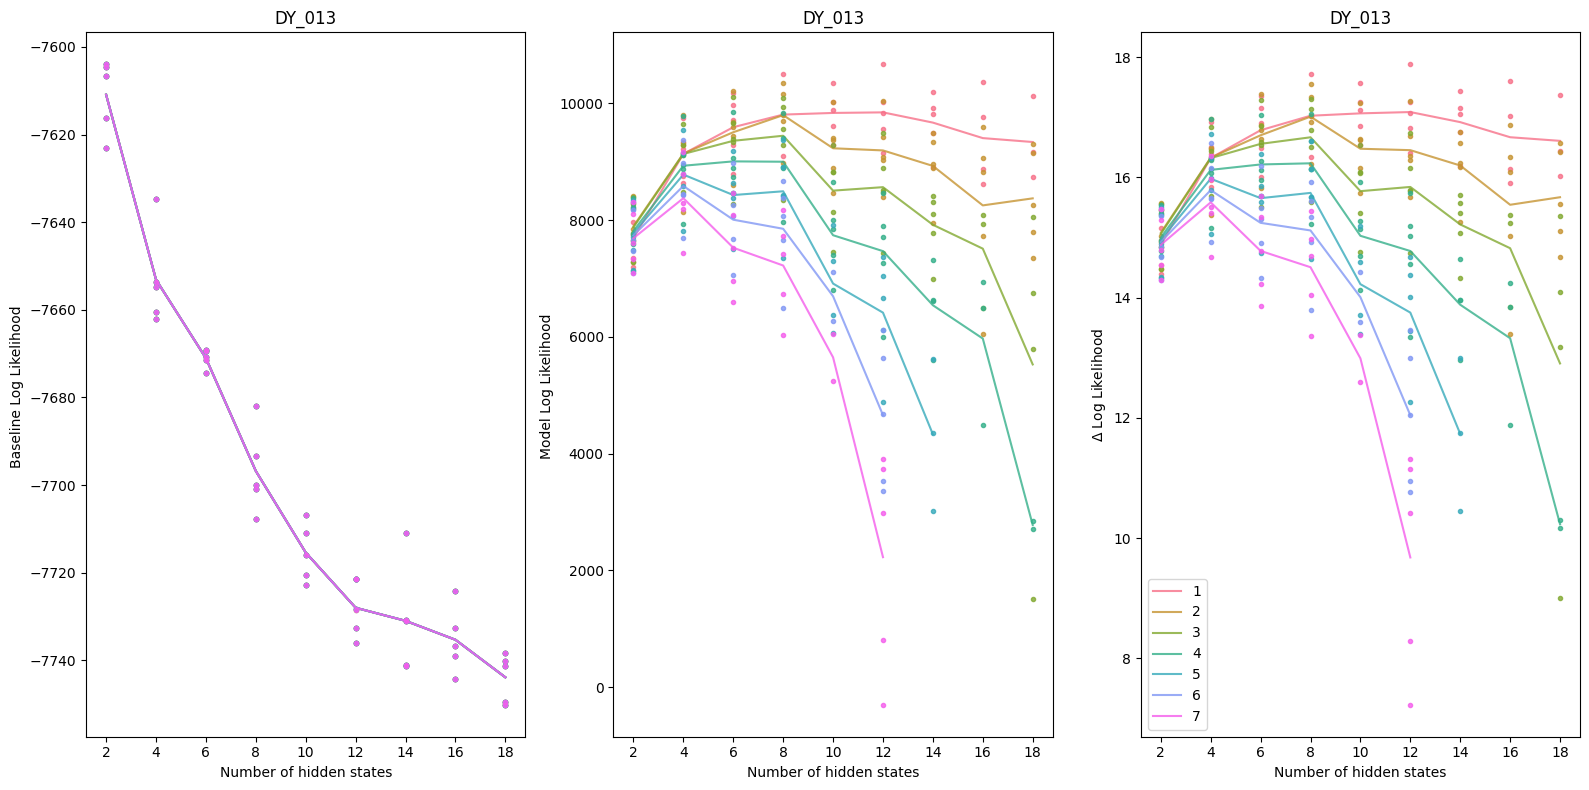

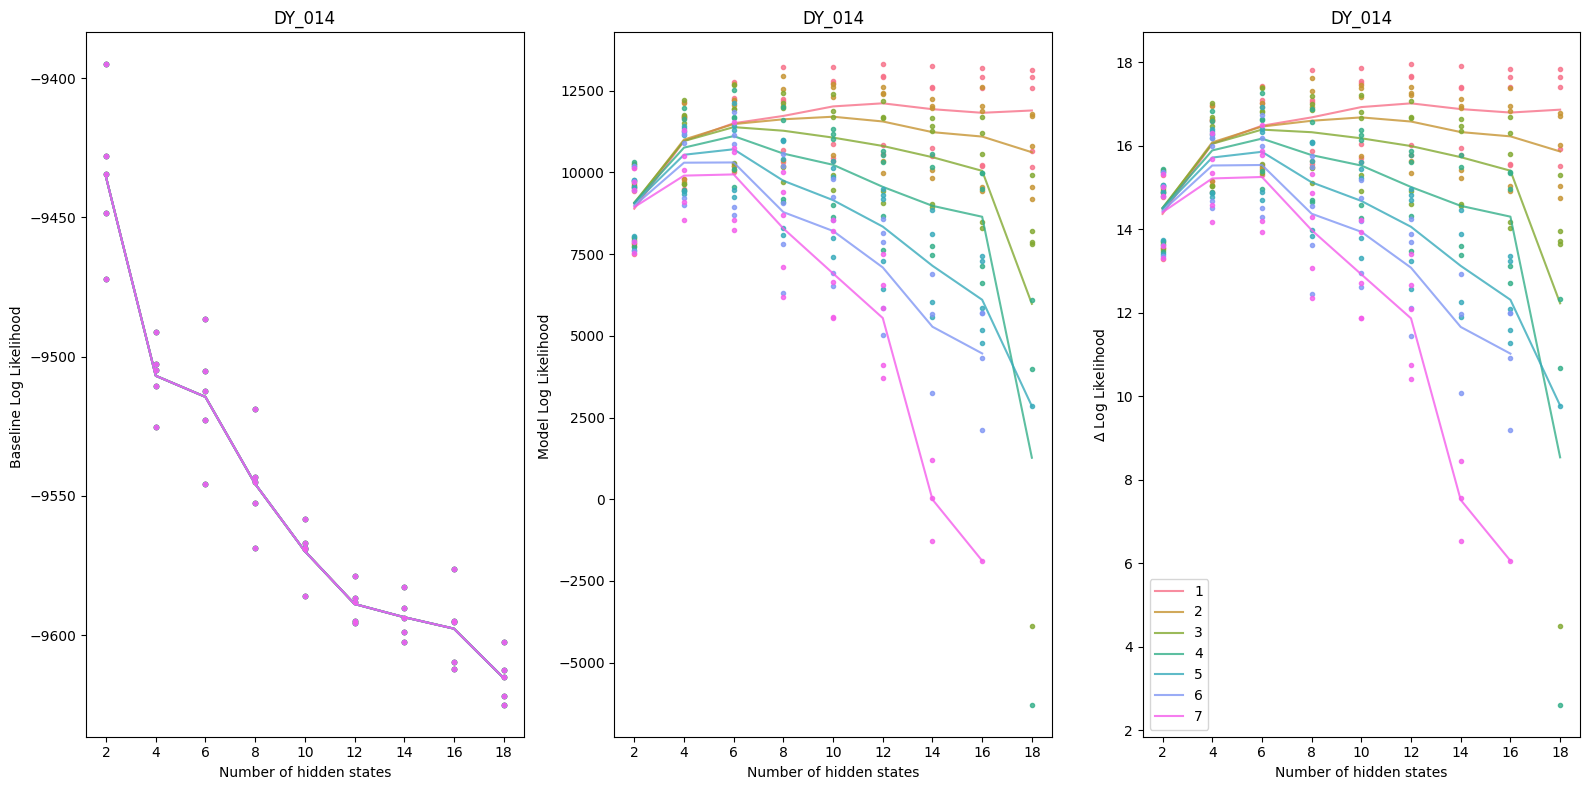

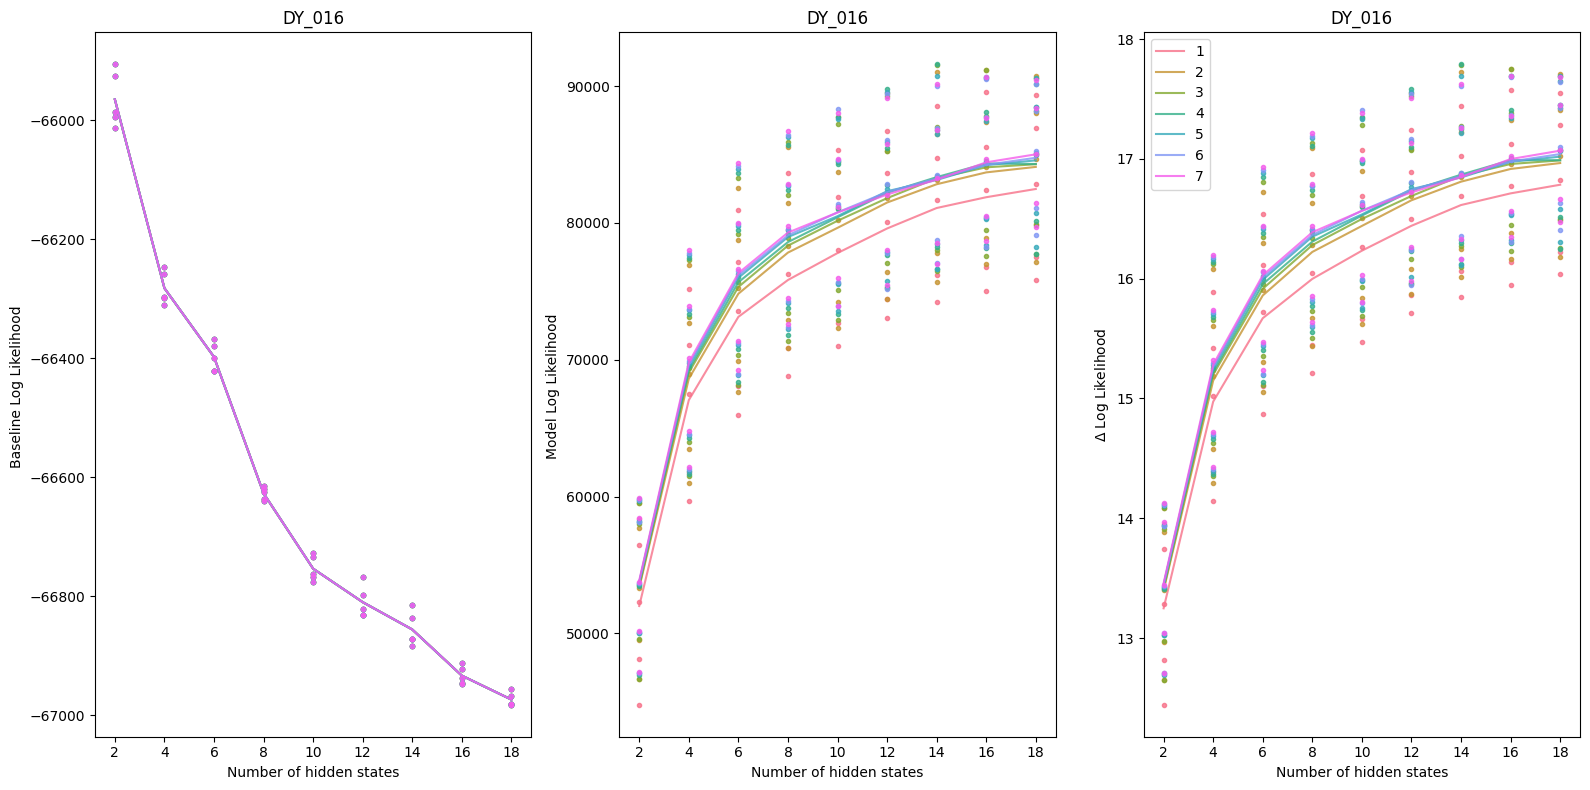

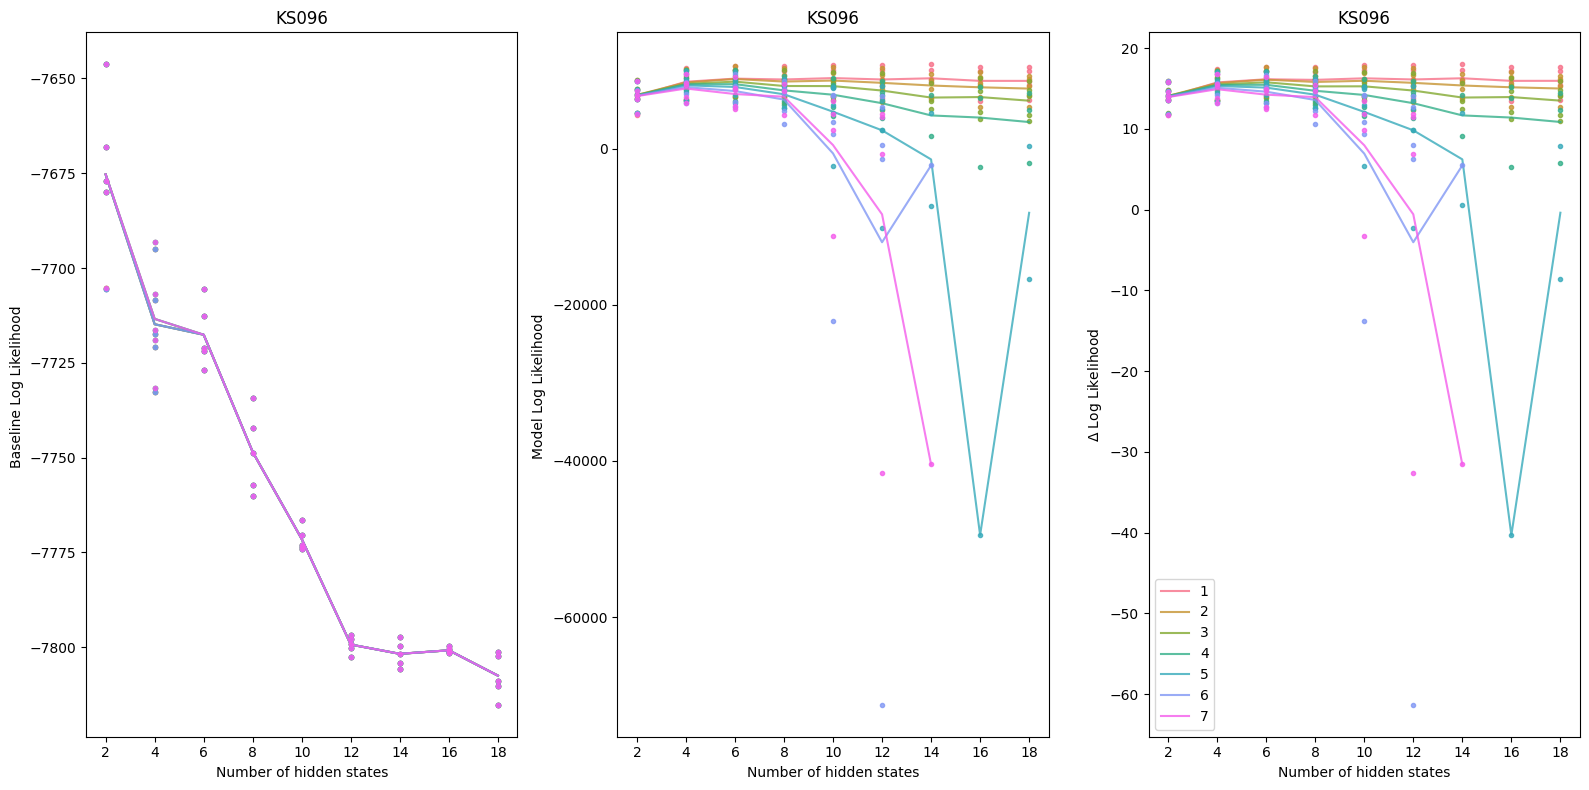

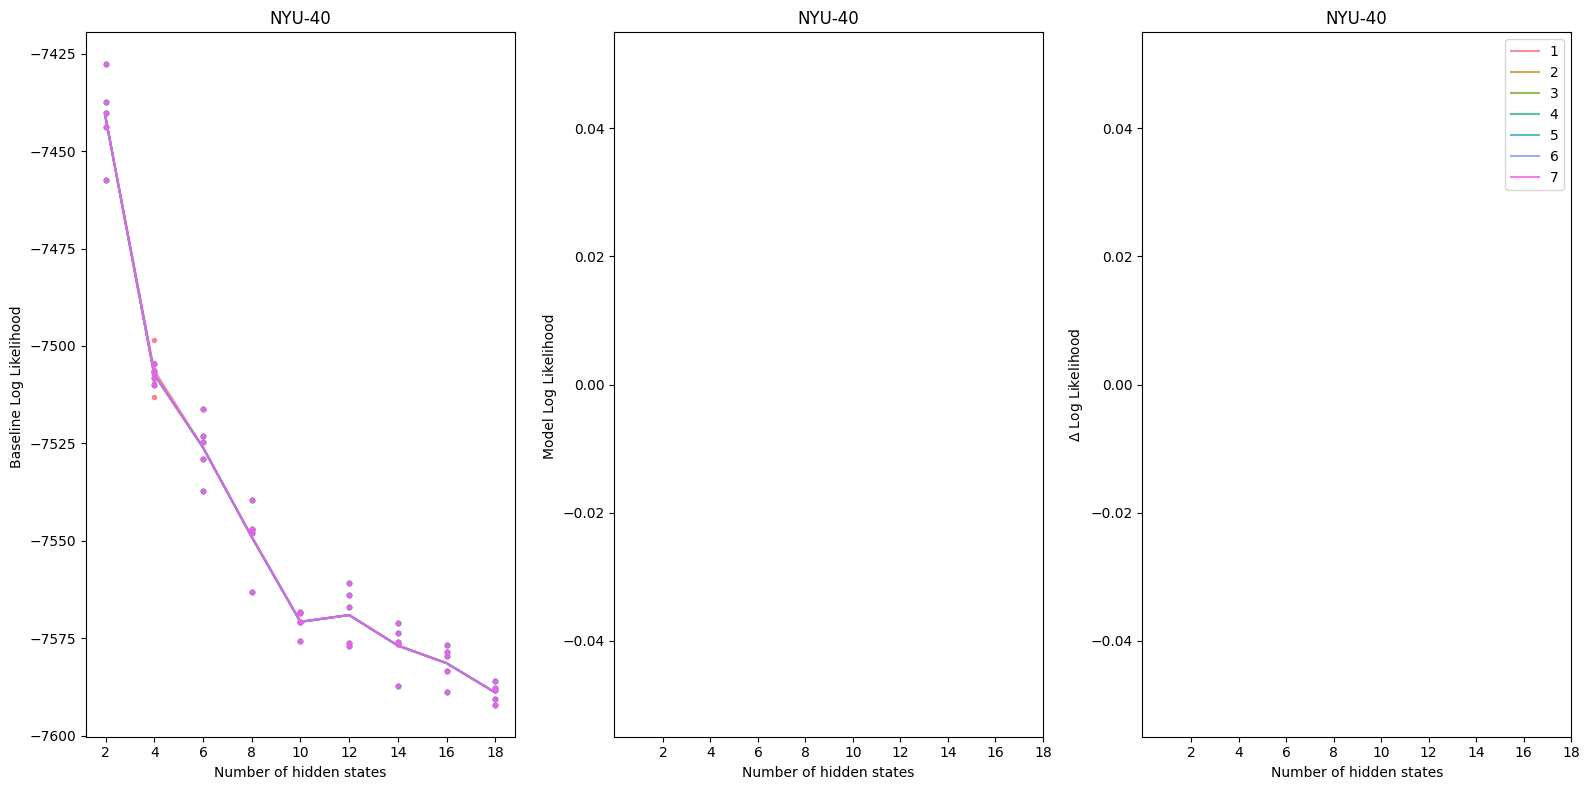

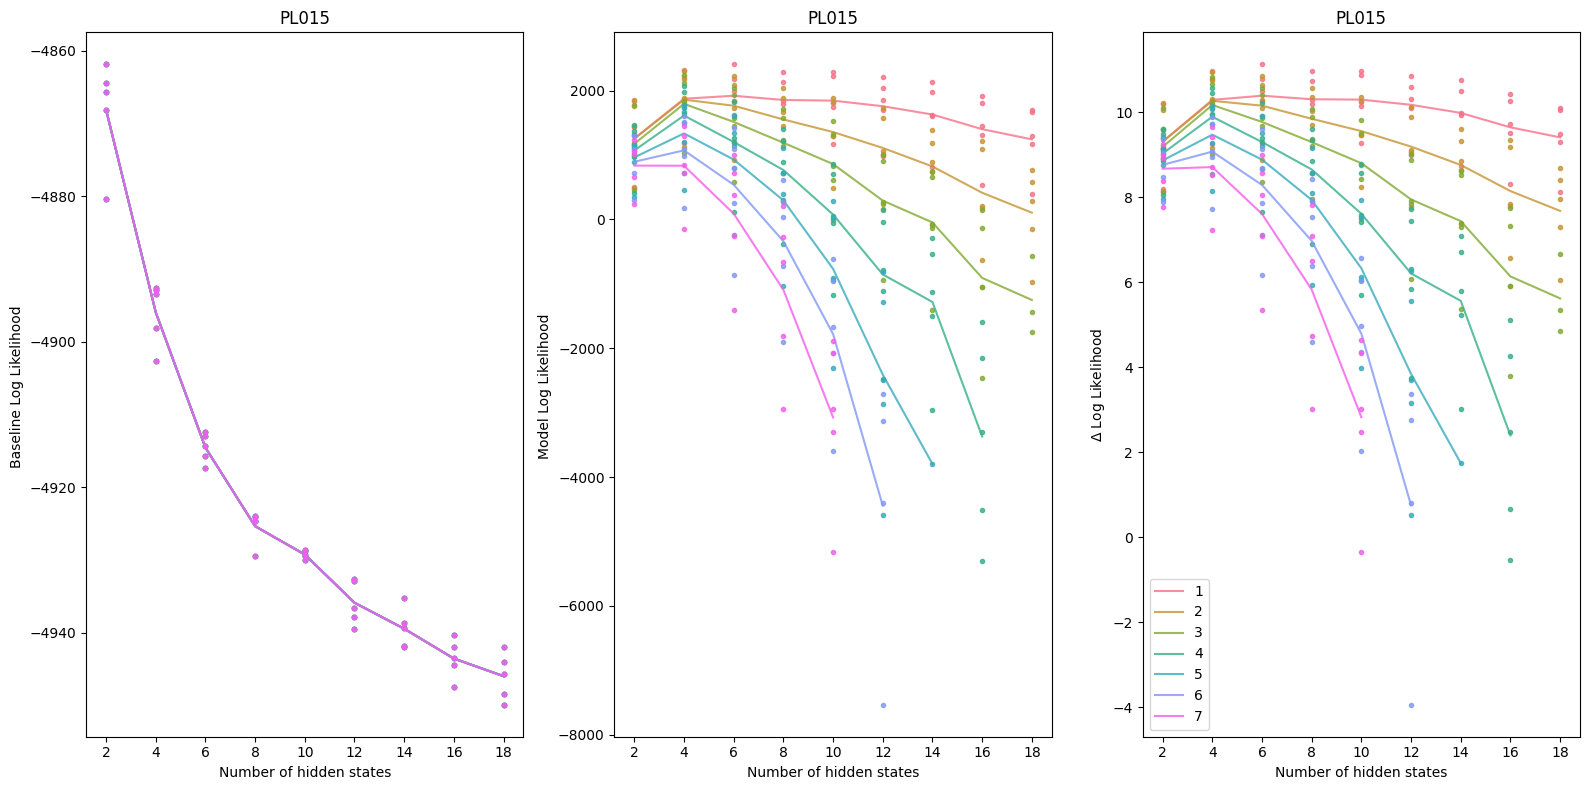

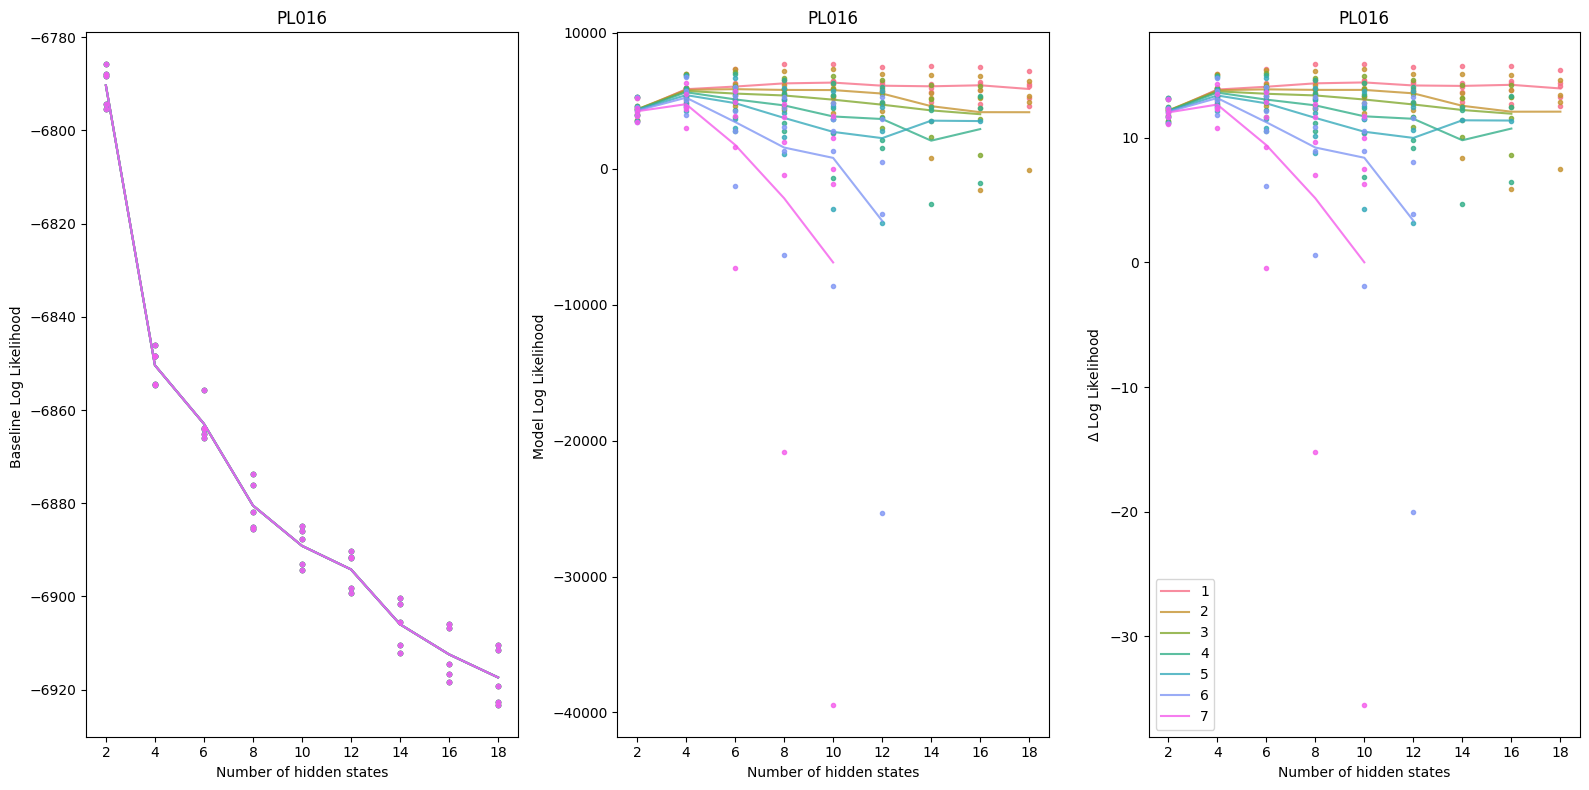

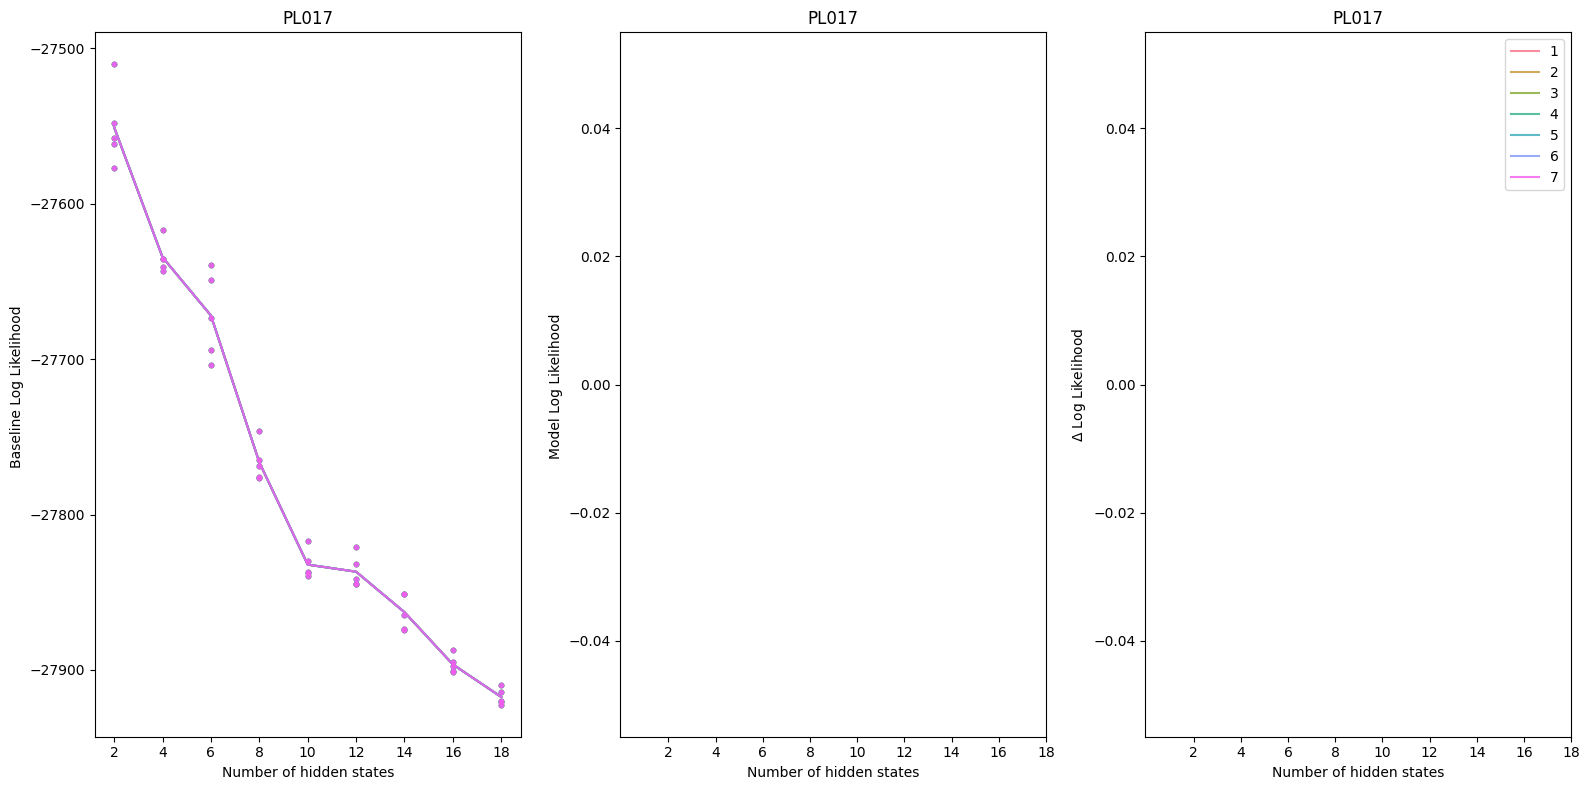

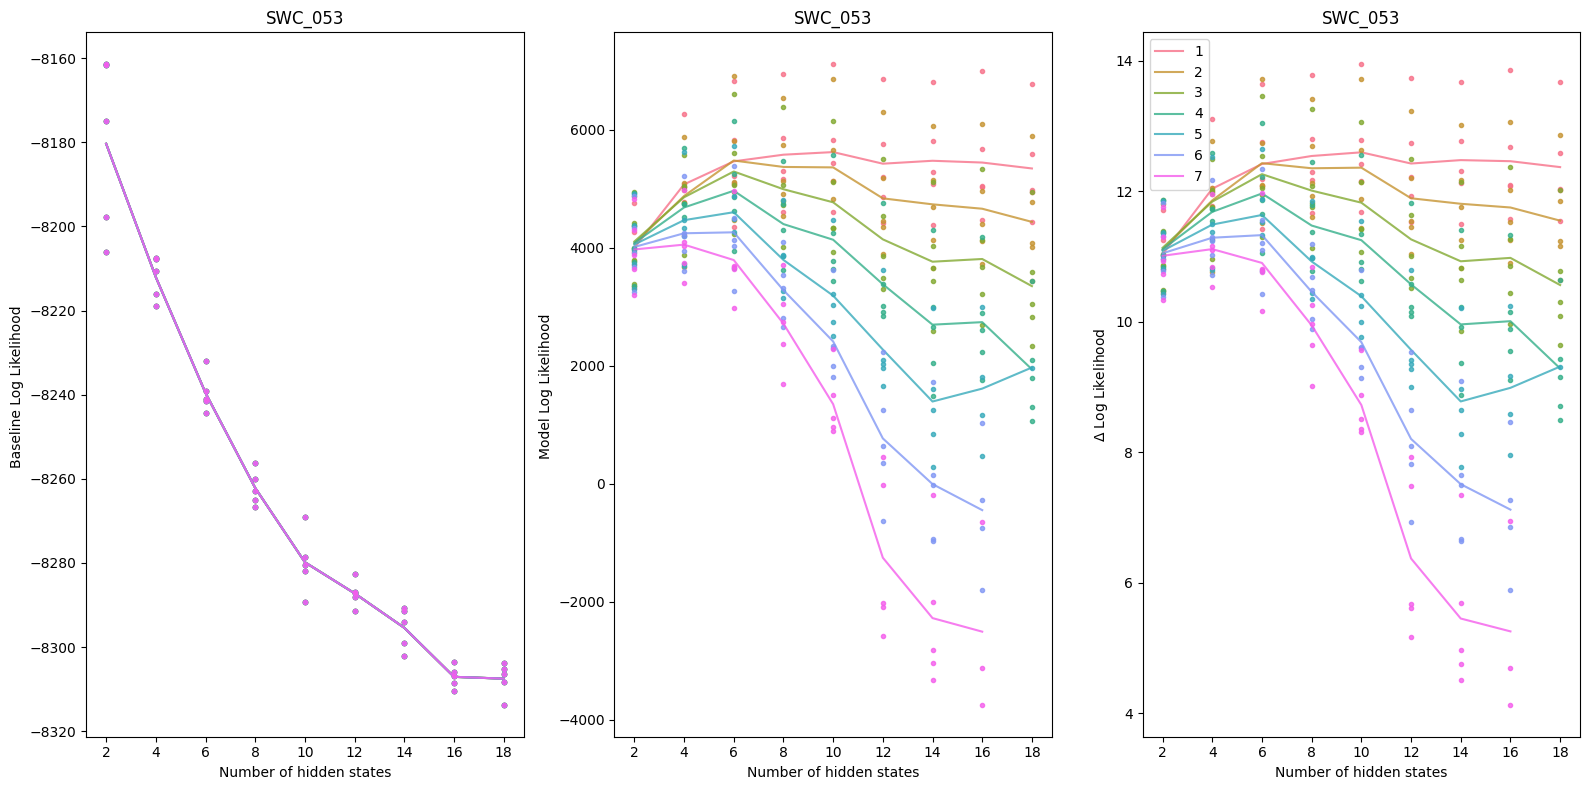

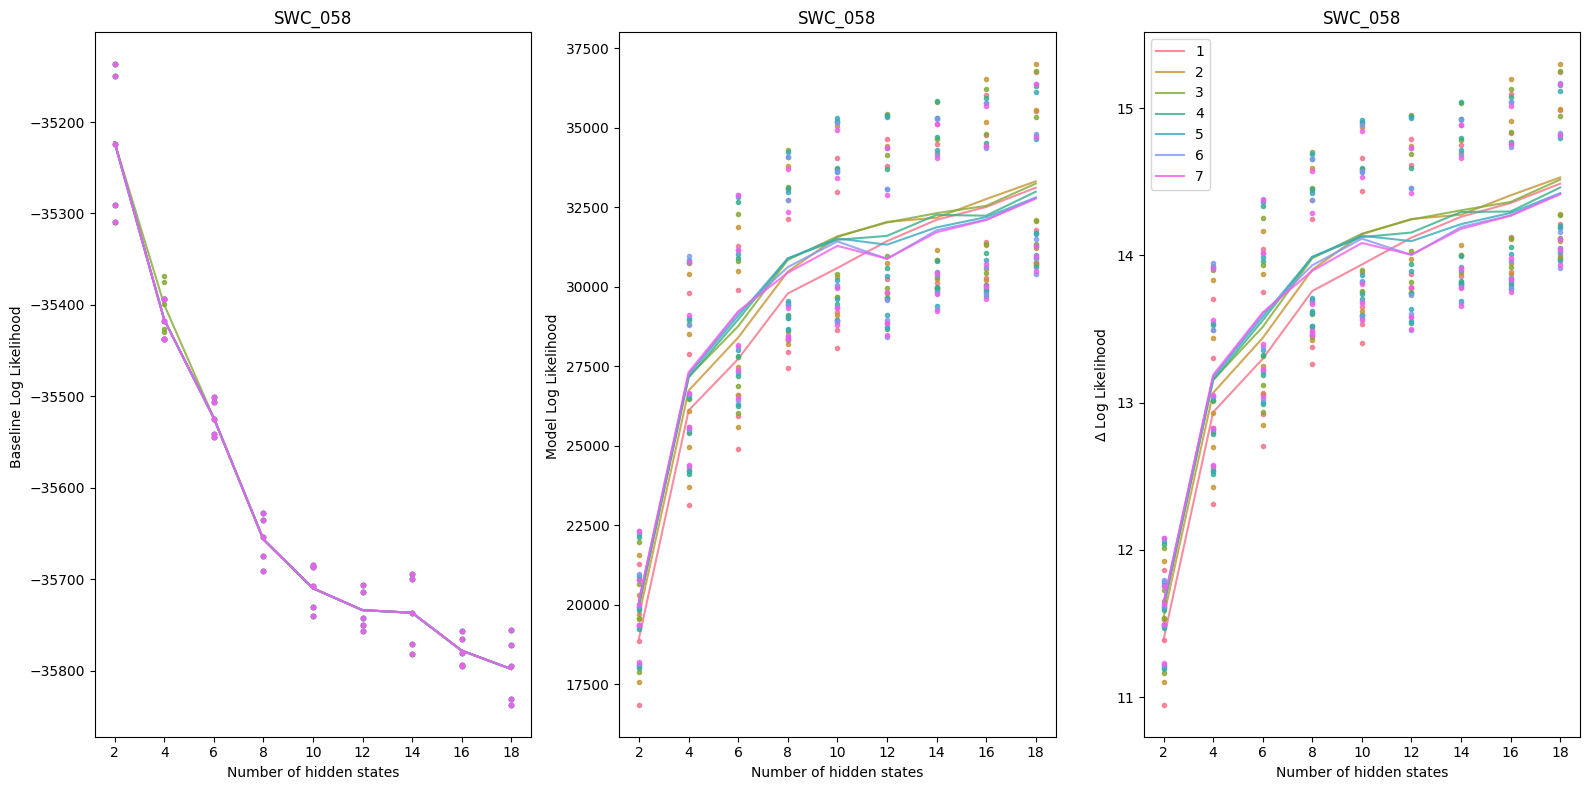

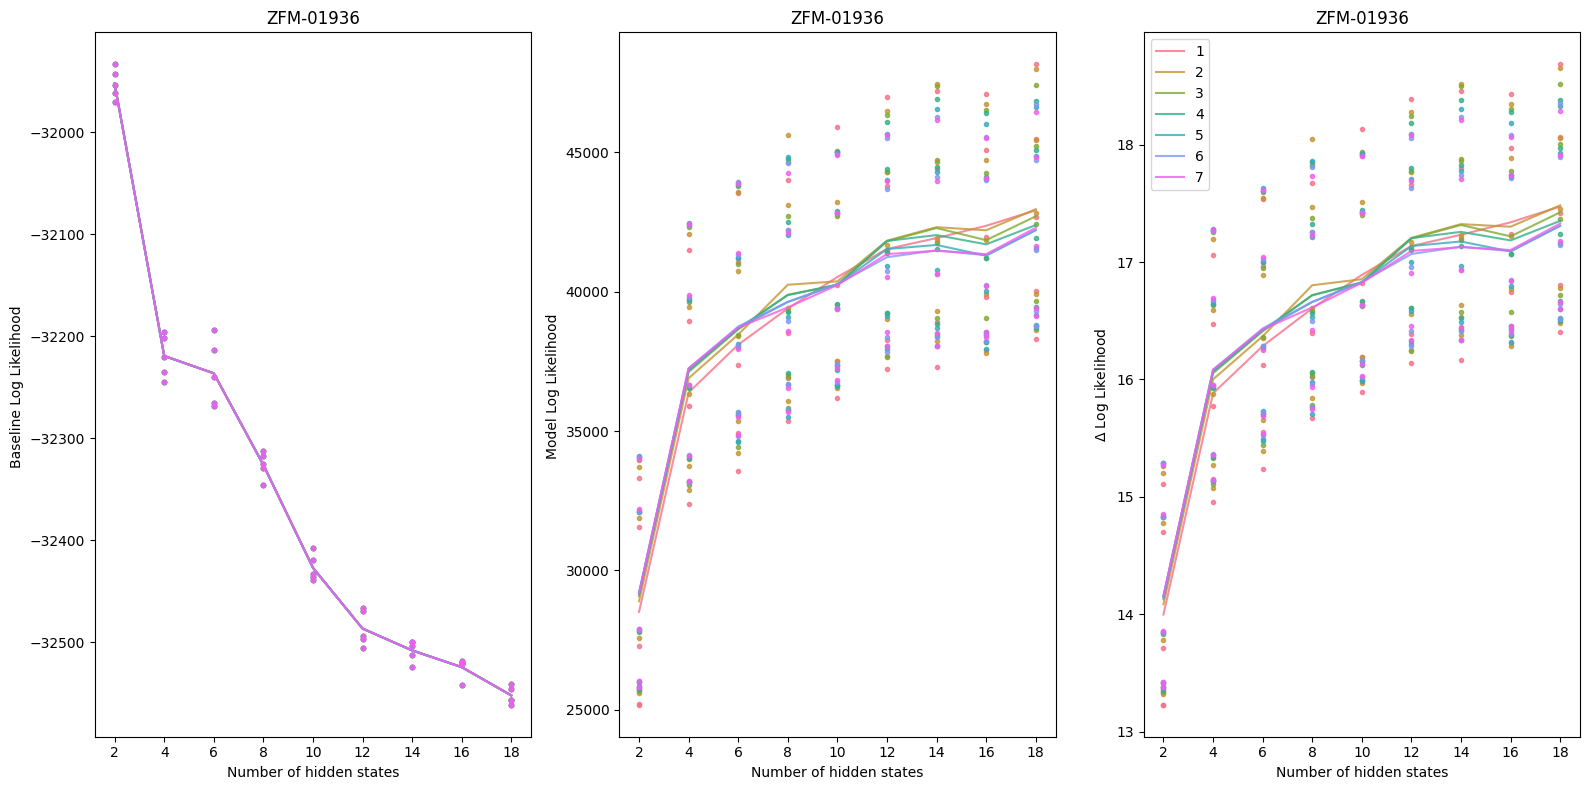

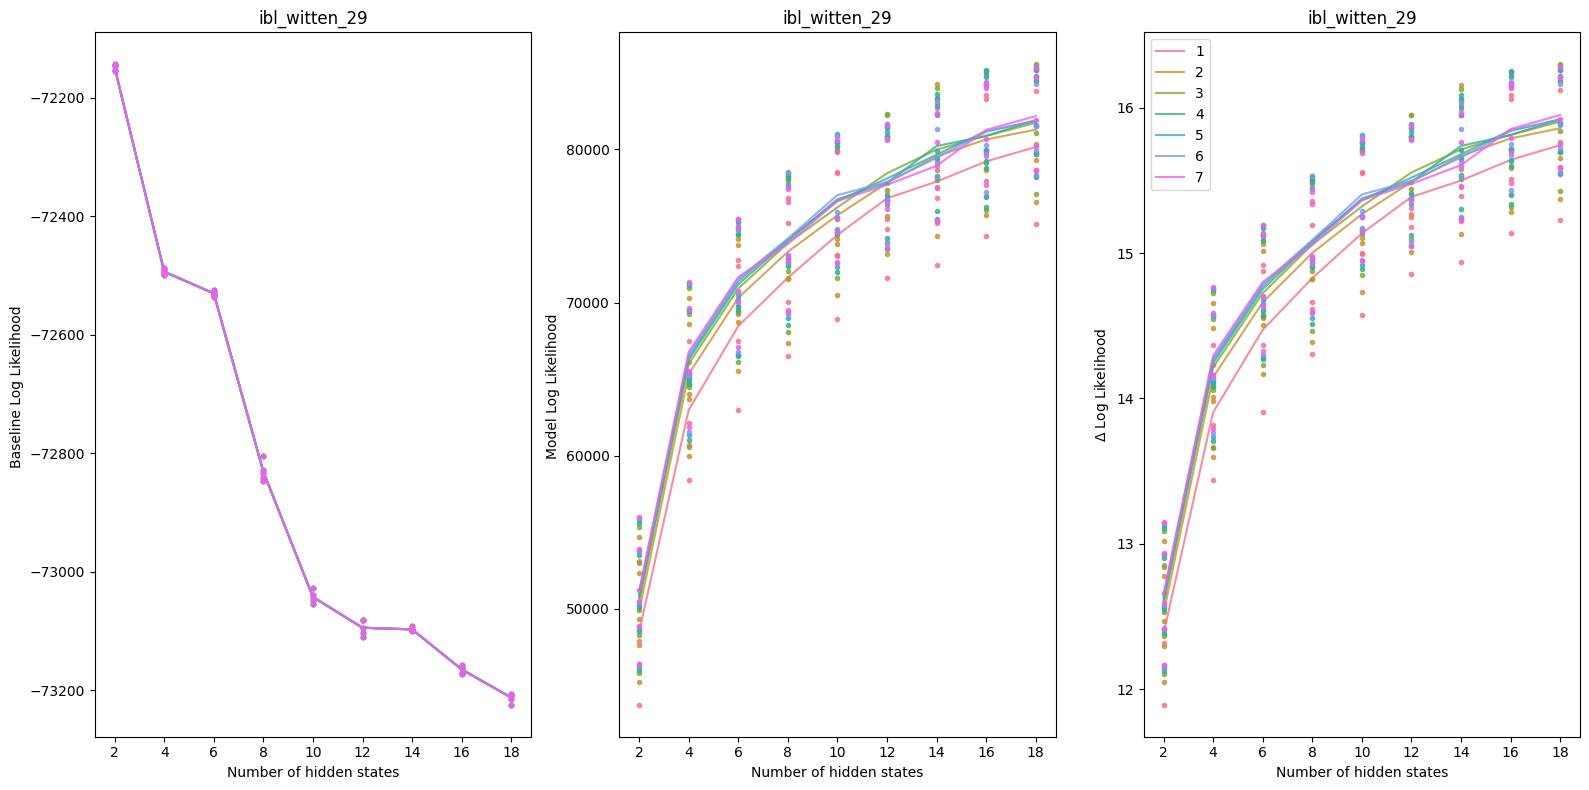

In [93]:
States = list(range(start_step, last_state, state_step))
Lags = list(range(start_lag, last_lag, lag_step))

# Generate the list of colors
colors = generate_colors(len(Lags))

# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)):
    # mouse_name = 'DY_013'
    if len(mouse_name) > 0:
        
        # Get mouse data
        session_trials = session_all[mouse_name]
        design_matrix = matrix_all[mouse_name]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            
        # Prepare data for cross-validation
        num_timesteps = np.shape(design_matrix)[0]
        emission_dim = np.shape(design_matrix)[1]
        shortened_array = np.array(design_matrix[:(num_timesteps // num_train_batches) * num_train_batches])
        train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))

        # Split data into folds
        fold_len =  len(shortened_array)/num_train_batches
        
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=[16, 8])
        for l, lag in enumerate(Lags):
            
            avg_val_lls = all_lls[mouse_name][lag]
            baseline_lls = all_baseline_lls[mouse_name][lag]
            bits_LL = (np.array(avg_val_lls) - np.array(baseline_lls)) / fold_len * np.log(2)
            
            axs[0].plot(all_num_states, np.nanmean(baseline_lls, axis=1), color=colors[l], label=str(lag), alpha=0.8)
            for k, per_fold_val_lls in zip(all_num_states, baseline_lls):
                axs[0].plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.', color=colors[l], alpha=0.8)
            axs[0].legend()
            axs[0].set_title(mouse_name)
            axs[0].set_xticks(States)
            axs[0].set_xlabel("Number of hidden states")
            axs[0].set_ylabel("Baseline Log Likelihood ")
            # axs[0].set_ylim([5, 15])
            
            axs[1].plot(all_num_states, np.nanmean(avg_val_lls, axis=1), color=colors[l], label=str(lag), alpha=0.8)
            for k, per_fold_val_lls in zip(all_num_states, avg_val_lls):
                axs[1].plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.', color=colors[l], alpha=0.8)
            axs[1].legend()
            axs[1].set_title(mouse_name)
            axs[1].set_xticks(States)
            axs[1].set_xlabel("Number of hidden states")
            axs[1].set_ylabel("Model Log Likelihood ")
            
            axs[2].plot(all_num_states, np.nanmean(bits_LL, axis=1), color=colors[l], label=str(lag), alpha=0.8)
            for k, per_fold_val_lls in zip(all_num_states, bits_LL):
                axs[2].plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.', color=colors[l], alpha=0.8)
            axs[2].legend()
            axs[2].set_title(mouse_name)
            axs[2].set_xticks(States)
            axs[2].set_xlabel("Number of hidden states")
            axs[2].set_ylabel("$\Delta$ Log Likelihood ")
            # axs[2].set_ylim([, 14])

            axs[0].legend().remove()
            axs[1].legend().remove()
            plt.tight_layout()
        plt.show()

### Plot grid with LL

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: All-NaN slice encountered
  return f_raw(*args, **kwargs)



NYU-40
PL017


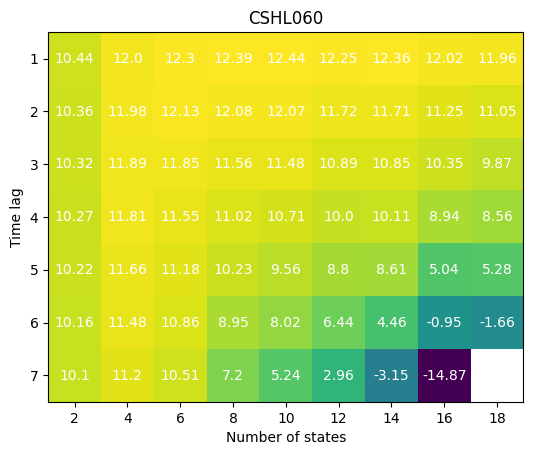

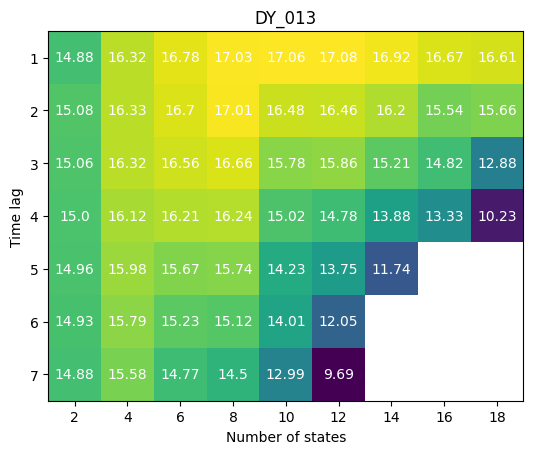

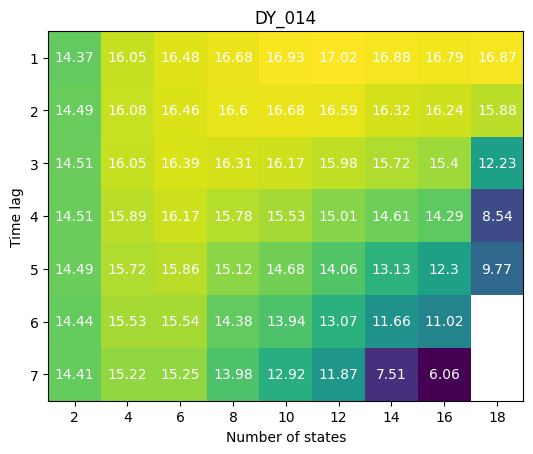

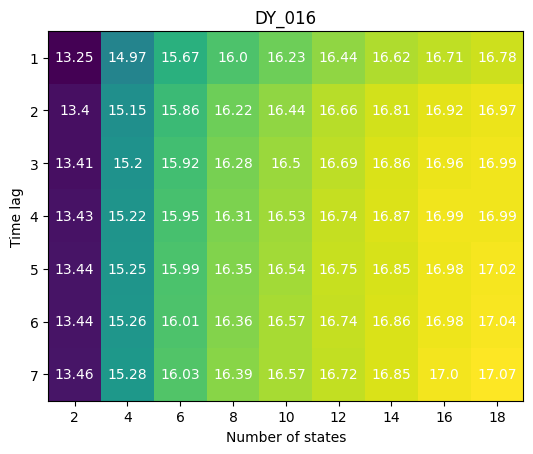

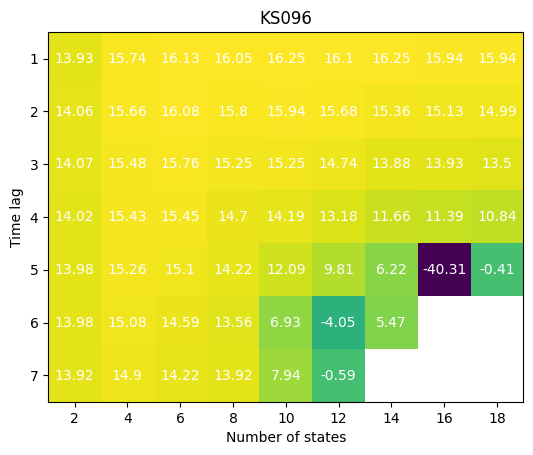

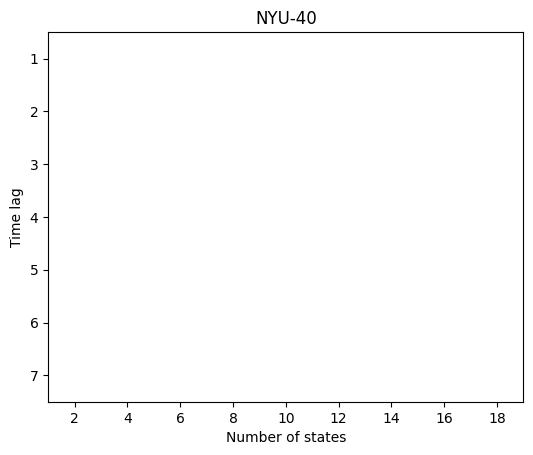

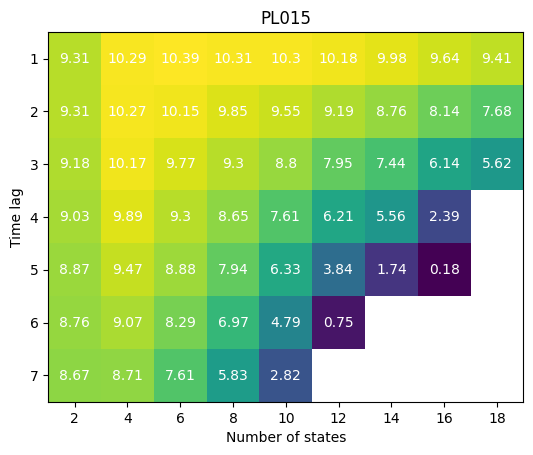

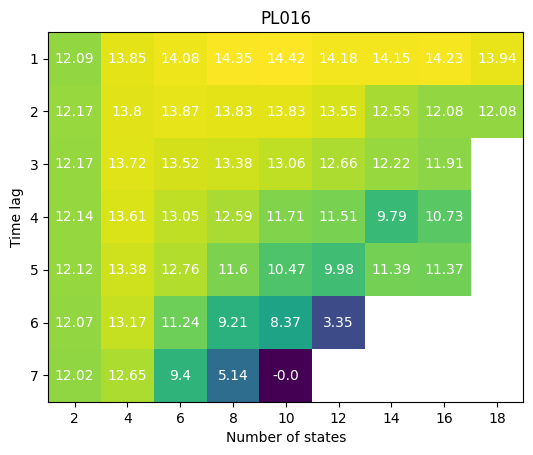

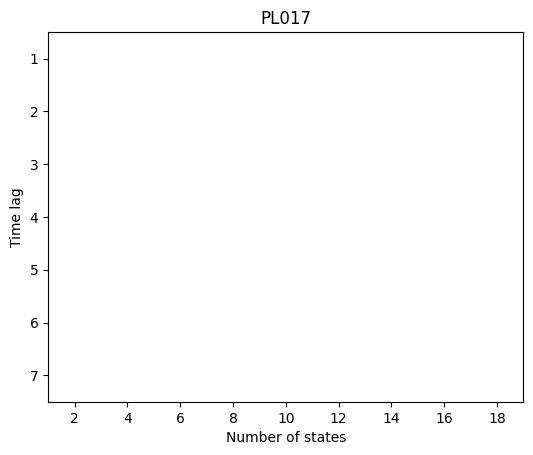

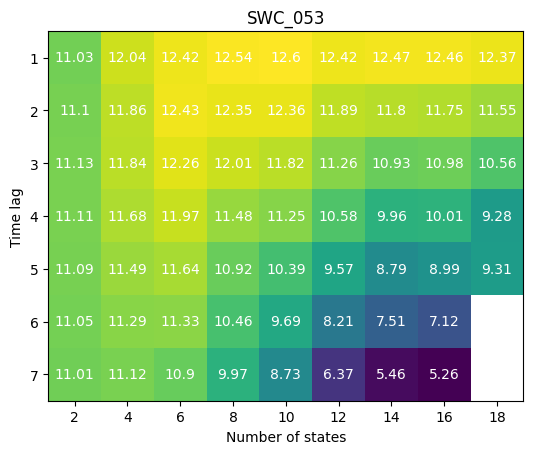

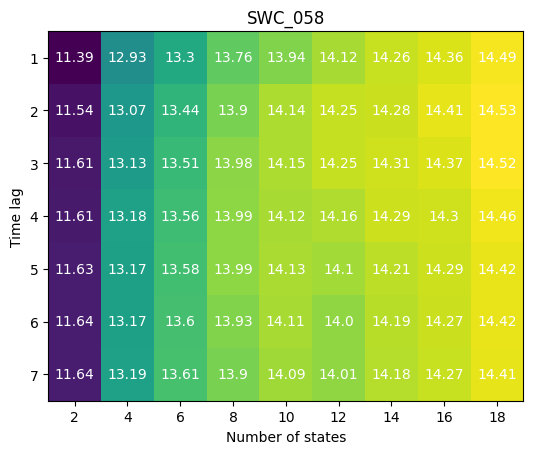

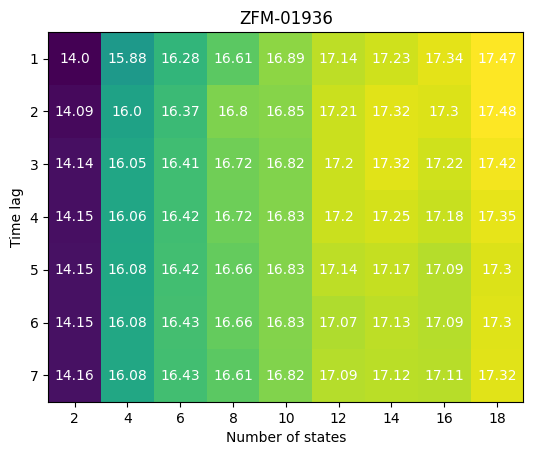

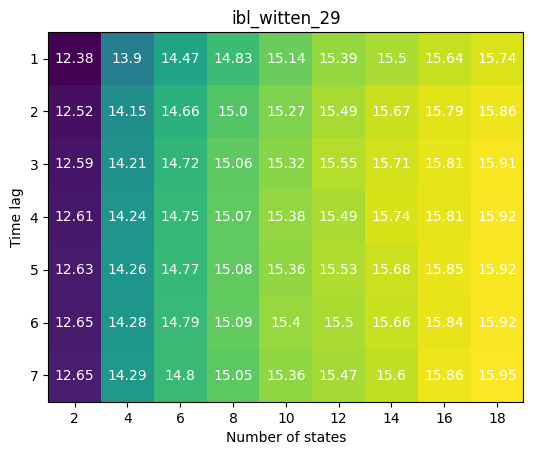

In [14]:
States = list(range(start_step, last_state, state_step))
Lags = list(range(start_lag, last_lag, lag_step))

_, _, lls_lag_state = best_params(all_lls, all_baseline_lls, mouse_names, session_all, matrix_all, num_train_batches, Lags)

# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)):
    # mouse_name = 'DY_013'
    if len(mouse_name) > 0:

        fig, ax = plt.subplots()
        im = ax.imshow(lls_lag_state[mouse_name])

        # Show all ticks and label them with the respective list entries
        ax.set_yticks(np.arange(len(Lags)), labels=Lags)
        ax.set_xticks(np.arange(len(States)), labels=States)
        plt.xlabel('Number of states')
        plt.ylabel('Time lag')
        plt.title(mouse_name)
        # Loop over data dimensions and create text annotations.
        for i in range(len(Lags)):
            for j in range(len(States)):
                text = ax.text(j, i, np.round(lls_lag_state[mouse_name][i, j], decimals=2),
                            ha="center", va="center", color="w")


### Plot scatterplot for best params


NYU-40
PL017


Text(0, 0.5, 'Time lag')

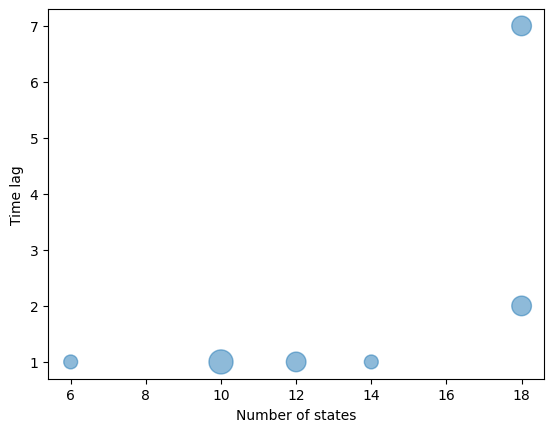

In [15]:
best_lag, best_state, _ = best_params(all_lls, all_baseline_lls, mouse_names, session_all, matrix_all, num_train_batches, Lags)

data = {'States': best_state, 'Lags': best_lag}
df = pd.DataFrame(data)

# Group by X and Y values and count the number of occurrences
grouped_data = df.groupby(['States', 'Lags']).size().reset_index(name='count')

# Scatter plot with marker size based on the count
plt.scatter(grouped_data['States'], grouped_data['Lags'], s=grouped_data['count']*100, alpha=0.5)
plt.xlabel('Number of states')
plt.ylabel('Time lag')


In [38]:
save_data = defaultdict(list)
save_data['mouse_names'] = []
save_data['mouse_names'] = np.unique(mouse_names)
save_data['best_lag'] = []
save_data['best_lag'] = best_lag
save_data['best_state'] = []
save_data['best_state'] = best_state

In [42]:
pickle_file = open('best_results', 'wb')
pickle.dump(save_data, pickle_file)